# 2022 Business Analytics Chapter 2: Kernel Based Learning😉
## Support Vector Machine(Classifier) Python Tutorial
### 2022010558 김지현🐲

-------

## SVM(Support Vector Machine)

__SVM(Support Vector Machine)__ 은 러시아 과학자 _Vladimir Vapnik_ 가 1970년대 후반 제안한 알고리즘입니다. 당시에는 크게 주목받기 못하였으나 1990년대에 들어 분류(Classification) 문제에서 우수한 일반화(Generalization) 능력이 입증되며 인기가 급부상한 머신러닝 알고리즘입니다. 또한 데이터가 고차원이거나 선형으로 분류할 수 없는 경우에도 사용할 수 있고, 이상치 탐지 등 보다 복잡하고 광범위한 경우의 분류 문제에도 적합하다는 점에서 많은 주목을 받아왔습니다.  
본 튜토리얼에서는 Kernel-Based Learning의 하나인 __Support Vector Machine__ 모델을 `python` `Scikit-Learn`을 통해 구현해보고자 합니다. 더불어 SVM은 우수한 분류 성능을 가지고 있지만 실행하는 데 있어 __여러 Hyperparameter에 의해 성능이 좌우된다는 문제__ 를 가지고 있습니다. 이는 사용하는 데이터 및 풀고자 하는 문제에 따라 달라지며, 따라서 최적의 Hyperparameter가 무엇인지 실험적으로 증명해야 하는 것이 필수적입니다. SVM의 대표적 Hyperparameter로는 __Linear Soft SVM__ 의 `C`(Penalty Term), __Kernel SVM__ 에서의 `kernel type`, 및 Kernel 내의 파라미터인 `gamma`, `degree`, `nu` 등이 있습니다.   

따라서 본 튜토리얼에서는 SVM을 구현하는 것과 더불어 __어떤 Hyperparameter들이 적합한지 다양한 데이터셋을 통해 결과를 비교해보고, 해당 Hyperparameter의 의미에 대해 파악__ 해보고자 합니다.

------

## Import Necessary Libraries

In [345]:
import numpy as np
from scipy import stats
import rich

# For visualiation
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
sns.set_style("white")
sns.set_palette("Pastel1")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

# Dataset
from sklearn import datasets
from sklearn.datasets import make_blobs, make_classification, make_moons
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

# Modeling
from sklearn.svm import SVC
from sklearn.model_selection import  KFold, cross_val_score, train_test_split


import warnings
warnings.filterwarnings('ignore')

-----

## 1.1 Linear SVM Classification (Hard Margin)

이진 분류 예시를 들어보겠습니다. 호랑이🐯와 용🐲을 구분해야 하는 문제가 주어진다고 했을 때, 둘은 선형으로 분류가 된다고 가정하겠습니다. 이때 세 가지 Case의 결정 경계(Decision Boundary)가 만들어진다고 하면 우리는 어떤 분류기가 가장 Class를 잘 구분한다고 할 수 있을까요? Case 1의 분류기는 Train set을 틀리게 분류하기 때문에 $R_{emp}$, 경험적 위험이 다른 분류기보다 높습니다. 그리고 이를 여러 번 학습시켜 모델링 하면 Case 2, 3과 같이 모든 학습 데이터를 알맞게 분류하여 $R_{emp}$가 0인 결정 경계가 될 것입니다.   

이때 Case 2의 Decision Boundary와 Case 3의 Decision Boundary는 같은 성능을 가진 분류기가 될 텐데요, 그렇다면 __둘 중 어느 분류기를 선택__ 해야 할까요?

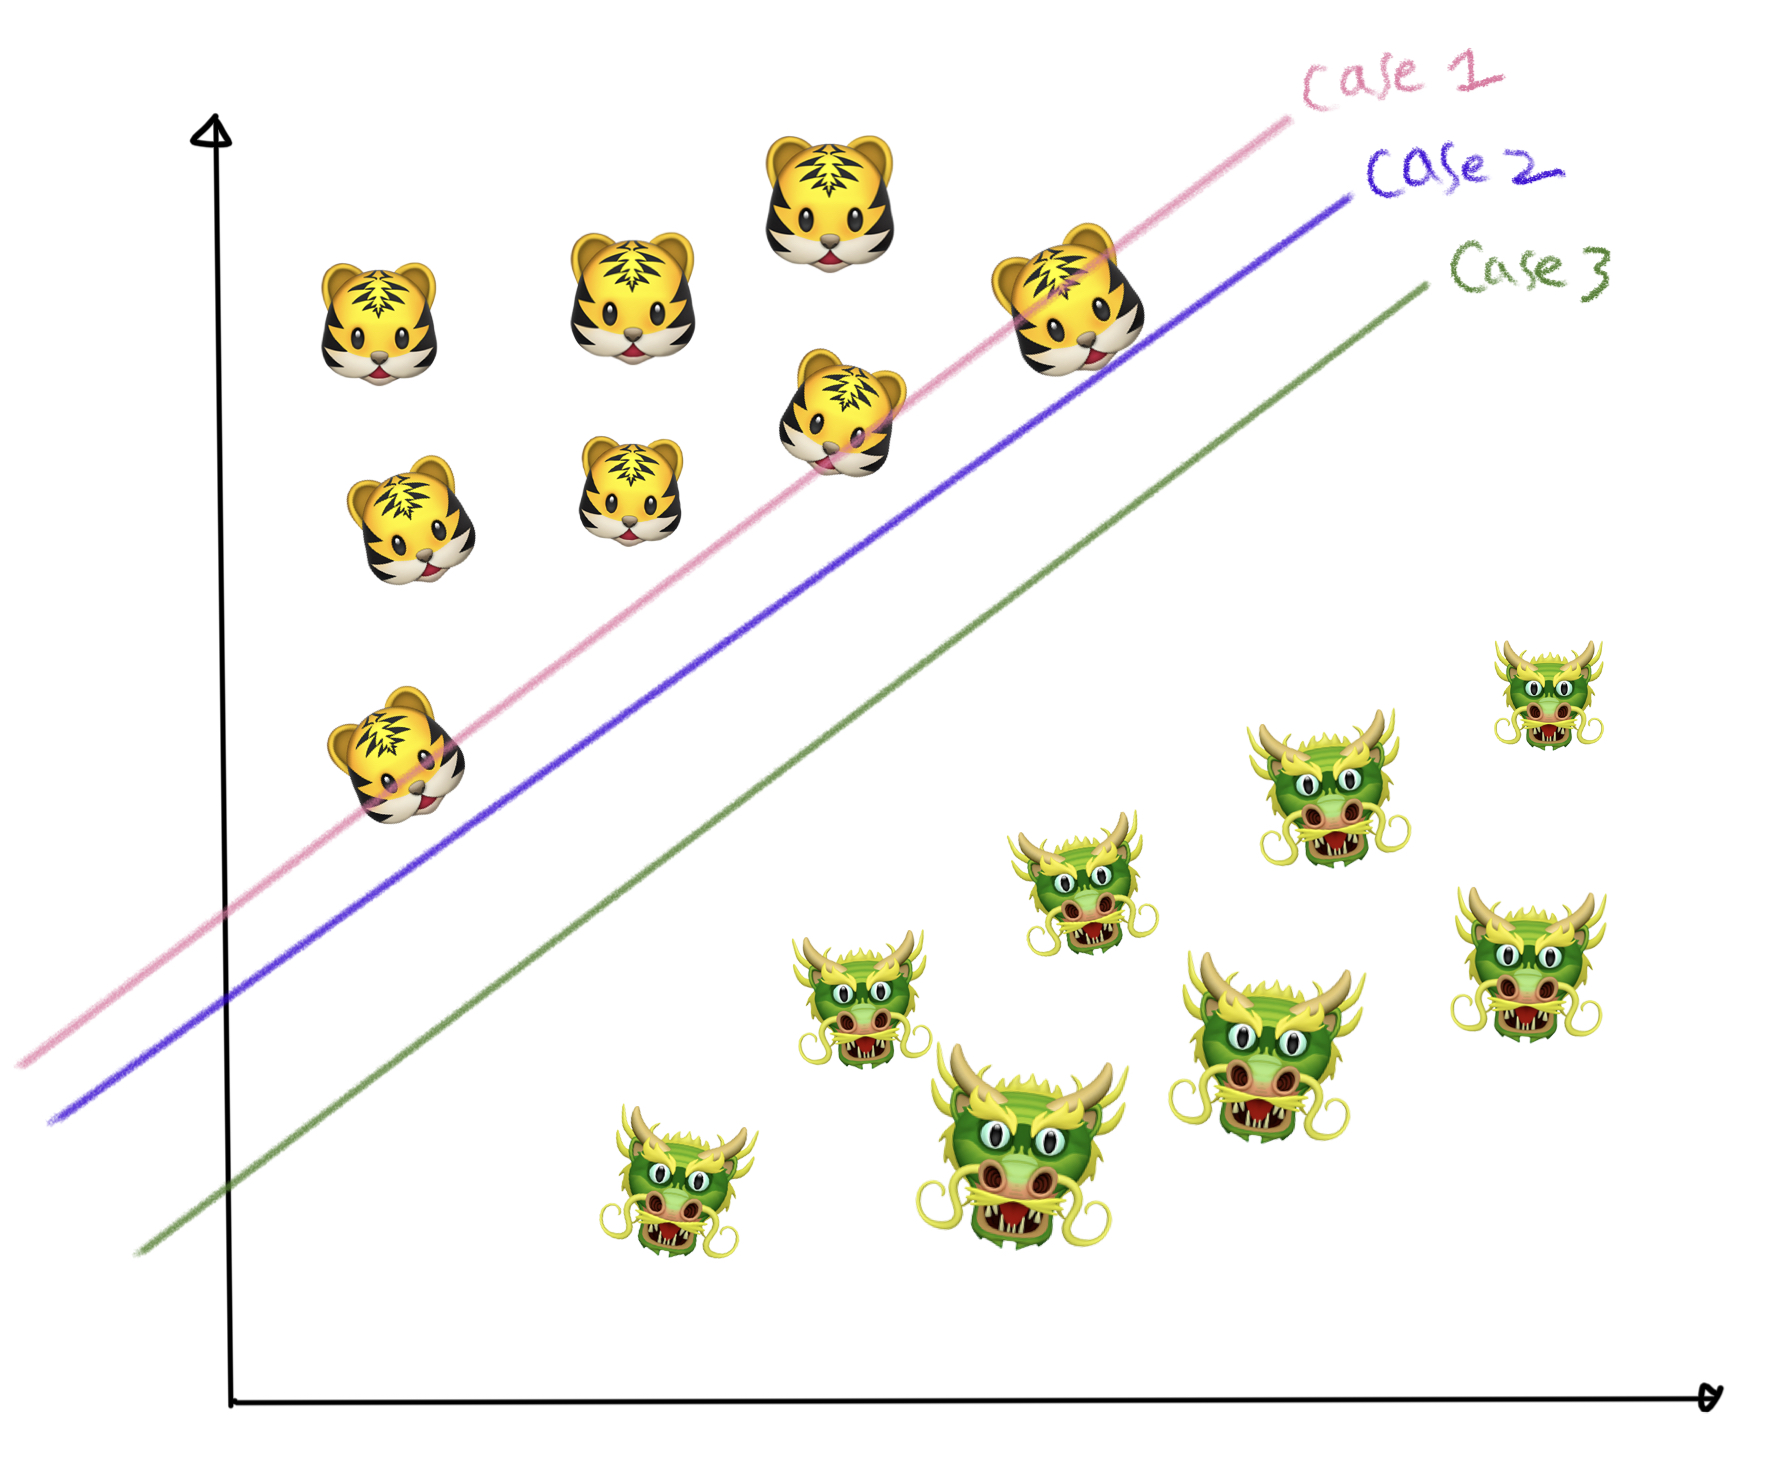

__<span style="color:crimson">일반화(Generalization) 측면__ 에서 보면, 우리는 Case 2 보다는 __<span style="color:crimson">Case 3 분류기를 더 선호__ 해야 합니다. Case 3 분류기가 2개의 Class를 구분하는 데 있어 __<span style="color:crimson">마진(Margin) 이 크기 때문__ 입니다.   

__마진(Margin)__ 이란 _'분류 경계면으로부터 가장 가까운 양쪽 범주의 객체와의 거리'_ 를 의미합니다. 직관적으로 생각해 보았을 때 이 마진이 넓어야 새로운 데이터가 들어왔을 때도 올바른 분류를 해낼 수 있겠죠. 만일 Case 2 분류기를 사용한다면 새로운 데이터를 용 Class로 분류할 확률이 더 높아질 것입니다. 따라서 __<span style="color:crimson">마진을 최대화 하는 것은 SVM에서 VC dimension (모델의 복잡도) 최소화와 더불어 구조적 위험 $R_{f}$ 최소화와 연결__ 되기도 합니다. 

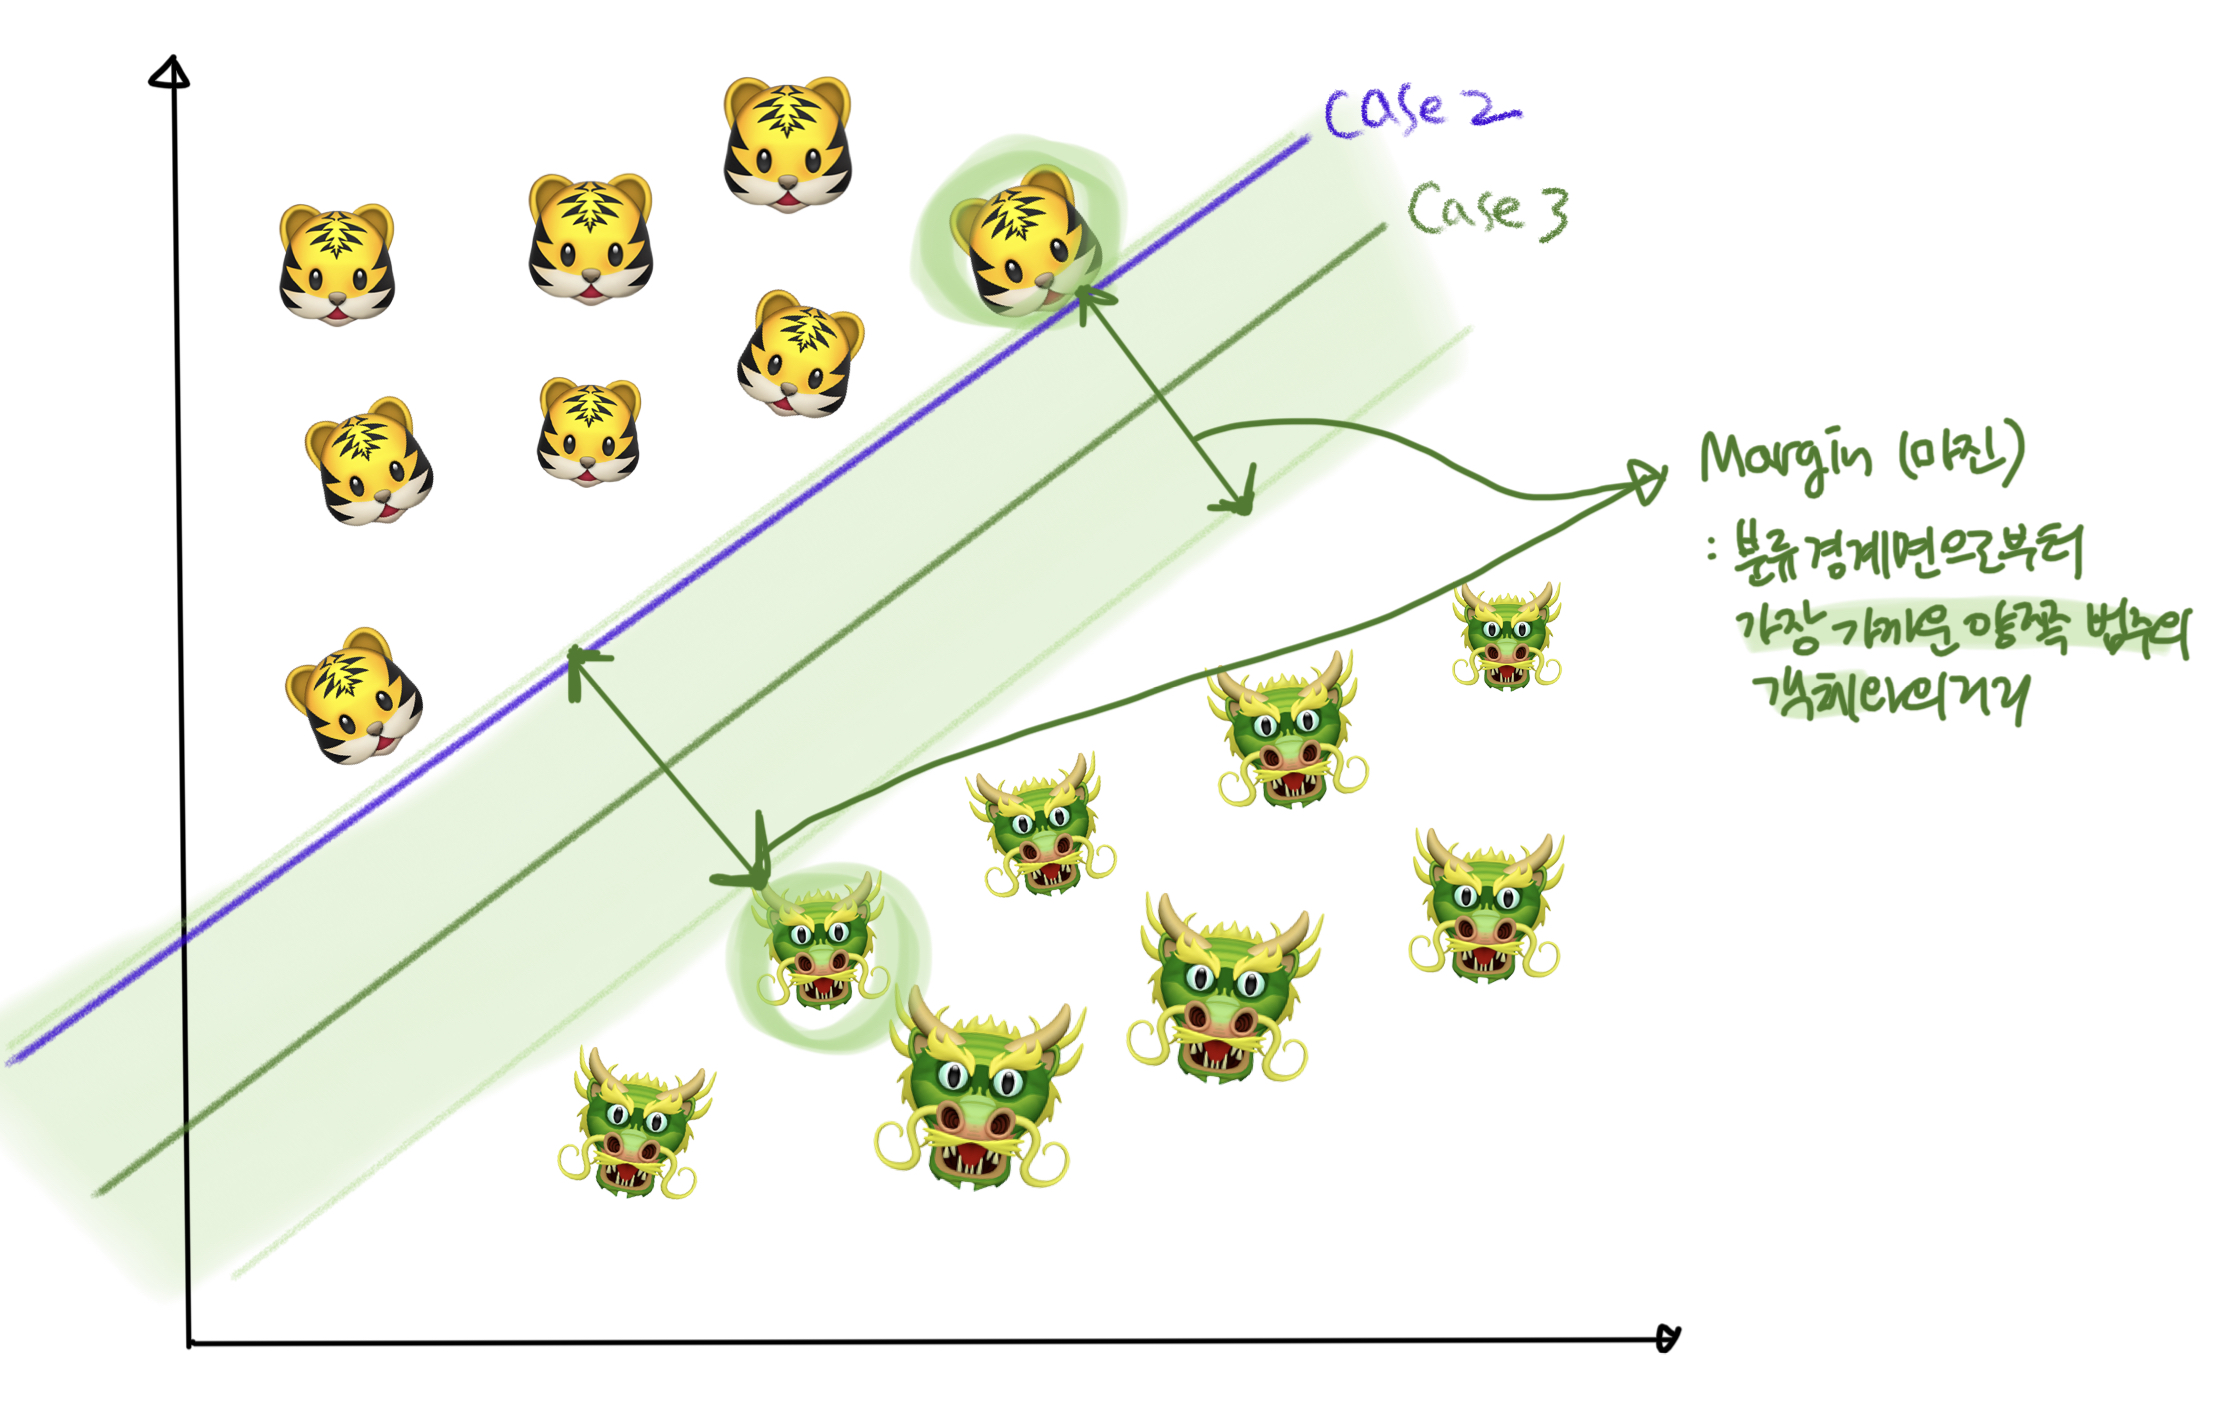

## 1.1.1 Linear SVM의 Decision Function

Linear SVM은 위 예시와 같이 두 개의 Class를 분리하기 위한 선형 결정 함수(Decision Function)를 찾는 것입니다. 이러한 결정 함수는 아래와 같이 나타낼 수 있습니다.   

$$f(x)=w^Tx+b=0$$   

이때 $f(x)$는 decision function으로, Class가 2개일 때 전체 Feature Space를 두 영역으로 분할합니다.
- $f(x) = w^Tx+b > 0 -> w_1$  (cf. $w_1$은 위 예시에서의 호랑이🐯)
- $f(x) = w^Tx+b < 0 -> w_2$  (cf. $w_2$는 위 예시에서의 용🐲)

하나의 Hyperplane을 표현하는 식은 여러 가지가 있는데, 이를 $p$라고 하였을 때 다음과 같이 나타낼 수 있습니다.
- $p\times (w^Tx+b) = 0 $

이때 $w$는 Hyperplane의 법선 벡터이며, $w$는 Hyperplane의 방향을 나타내고, $b$는 위치를 나타냅니다.  
- 따라서 임의의 점 $x$에서 hypersphere까지의 거리는 $h=\frac{|f(x)|}{||w||}$가 됩니다.

> __Hyperplane__  
> 데이터를 Class에 따라 나눌 수 있는 Decision Boundary를 의미합니다. SVM Classifier는 Margin을 최대화 하는 Hyperplane을 찾는 것이 목적이기에, 해당 Hyperplane을 `MMH` (`Maximum Margin Hyperplane`)이라 합니다.

## 1.1.2 Objective Function of (Hard Margin) SVM

앞서 설명했듯이, __<span style="color:crimson">SVM의 목적은 마진(margin)을 가장 크게 만드는 hyperplane의 방향__, 즉 $w$를 찾는 것입니다. 이 방향이 달라질 경우 마진이 어떻게 달라지는 지는 아래 그림과 같습니다.

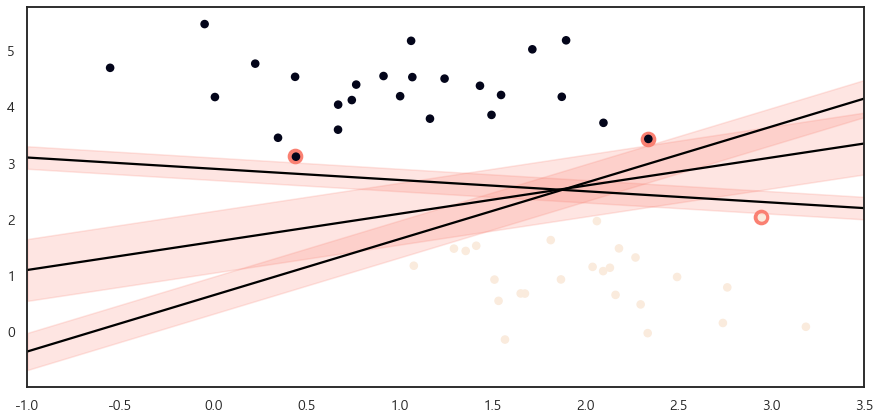

In [313]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

plt.figure(figsize=(15, 7))
xfit = np.linspace(-1, 3.5)

plt.scatter(0.441, 3.119, facecolor='salmon', s=200)
plt.scatter(2.3337, 3.4247, facecolor='salmon', s=200)
plt.scatter(2.9465, 2.0335, facecolor='salmon', s=200)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50);

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='salmon', alpha=0.2)

plt.xlim(-1, 3.5);

앞서 말했듯이 하나의 데이터셋을 분류할 수 있는 Hyperplane이 여러 가지 나올 때, 우리는 가장 넓은 폭을 가지는 마진의 Hyperplane을 선택해야 할 것입니다. 이때 위 그림에서 마진은 __<span style="color:indianred">분홍색으로 강조된 데이터들에 의해 결정__ 됩니다. 이러한 데이터를 __<span style="color:indianred">Support Vector__ 라고 합니다.

--------

### __<span style="color:teal">[실험 1] 학습 데이터 수에 따른 SVM Hyperplane 비교__

앞서 마진은 Support Vector의 위치에 따라 결정이 되고, 마진의 크기가 분류기의 성능과 직결됨을 알게 되었습니다. 이때 이를 딥러닝과 비교해보겠습니다. 딥러닝은 학습 데이터 수/양에 따라 모델의 성능이 달라지는데, Support Vector Machine도 그러할까요? __이때 Support Vector Classifier는 마진을 결정하는 Support Vector의 위치에 따라서는 달라지지만, 딥러닝과 같이 학습 데이터 수에 따라 직접적으로 달라진다고 보기는 어렵습니다.__ 데이터 수가 아무리 늘어나도 __<span style="color:teal">Support Vector의 위치가 바뀌지 않는다면 해당 데이터들이 SVM Classifier의 형성에 기여하지 않기 때문__ 입니다.   

딥러닝의 경우 모델의 구조적 위험 $R[f]$이 오로지 경험적 위험 $R_{emp}$에 의존합니다. 따라서 학습 데이터 수에 큰 영향을 받지만, __<span style="color:teal">SVM은 margin 평면 위에 위치하거나 이를 넘지 않는 이상, 다른 데이터의 위치의 수는 중요하지 않다는 차이점__ 이 있습니다. 이 예를 시각화를 통해 확인해보겠습니다. 데이터가 60개일 때와 120개일 때 모형이 달라지는 지를 비교한 것입니다.

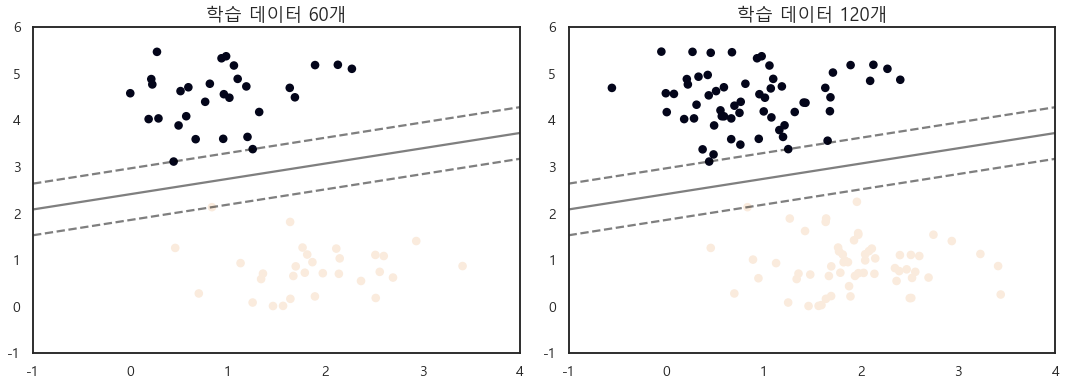

In [2]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1e10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50)
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('학습 데이터 {0}개'.format(N))

확인 결과 __<span style="color:teal">데이터 수가 2배 늘어났음에도 Support Vector는 달라지지 않았기에 Hyperplane에는 변화가 없음을 시각적으로 확인__ 하였습니다. 이는 앞서 말했듯이 __<span style="color:teal">Decision Boundary가 margin을 형성하는 Support Vector에 의해 결정되고 데이터 수에 따라 결정되는 것이 아니기 때문__ 입니다. 아래는 Jupyter notebook을 이용할 때 Interactive widget으로 데이터 수에 따른 SVM Classifier의 변화를 확인할 수 있도록 한 것입니다. 만일 10부터 300까지 데이터를 점차적으로 늘려갈 경우, SVM Classifier가 어떻게 달라지는 지 확인해보고자 합니다.

In [3]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 20, 30, 50, 60, 100, 120, 150, 200, 300], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 20, 30, 50, 60, 100, 120, 150, 200, 300), value=1…

### __<span style="color:teal">[실험 1] 결과 해석__

- __데이터 수 10~30 vs. 50__
    - 초반에 데이터 수가 적을 경우에는 마진이 매우 넓지만, 데이터 수가 50 이상이 될 때는 그 폭이 상대적으로 좁아진다는 것을 확인하였습니다. 그러니 이 폭 자체는 데이터 수가 50 이상이 되면 크게 변하지 않습니다.

- __데이터 수 50 vs. 100__
    - 마진의 폭 자체에는 큰 변화가 없습니다.  
    
- __데이터 수 60 vs 120__
    - 특히 데이터 수가 60에서 120까지는 Decision Boundary에도 차이가 없습니다.  
    
- __데이터 수 200 vs. 300__
    - SVM의 Hyperplane 즉 Classifier 모형 자체는 변하지 않습니다. __<span style="color:teal">Support Vector가 아닌, Hyperplane의 Decision Boundary로부터 멀리 떨어진 데이터가 아무리 늘어나더라도 분류 모형을 형성하는 데에는 영향이 없는 것__ 이죠.  

-------

### __<span style="color:teal">[실험 2] SVM은 데이터 스케일에 민감할까?__

위의 실험의 결과를 보니, Margin 형성에는 Support Vector들의 위치가 매우 중요한 것 같습니다. 다시 말해 __데이터 포인트들의 Feature Space 상에서의 위치가 SVM의 성능을 결정할 수도 있다__ 는 말인데, 그렇다면 __<span style="color:teal">데이터의 Scale이 모델에 직접적인 영향을 미치지 않을까요?__

<br/>

이러한 물을을 가지고 간단한 실험을 진행하였습니다. __<span style="color:teal">스케일에 차이가 나는 두 종류의 데이터셋을 만들어 보고, 이에 대해 SVM의 Hyperplane의 형태에 정말 차이가 있는지 확인__ 해보고자 합니다. 이때 X는 두 개의 변수를 가지는 2차원의 데이터이며, 두 변수는 값의 스케일이 다르다고 가정합니다.

### __<span style="color:teal">Case 1: 데이터 스케일 조정 전__

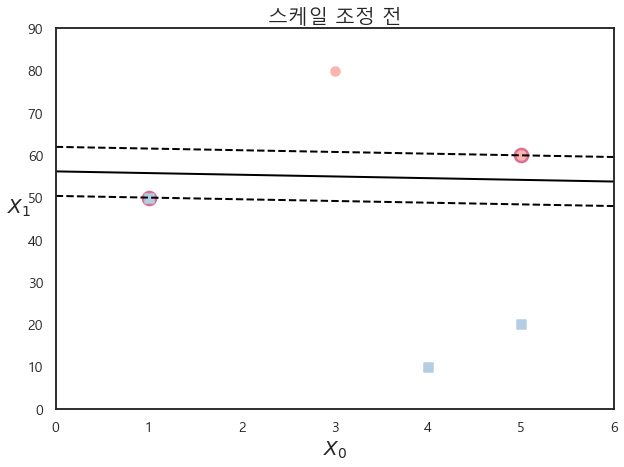

In [107]:
# Make Dataset: X는 2차원
X = np.array([[1, 50], [5, 20], [3, 80], [5, 60], [4, 10]]).astype(np.float64)
y = np.array([0, 0, 1, 1, 0])

# Modeling
model_tmp = SVC(kernel="linear", C=100)
model_tmp.fit(X, y)

# Plotting
plt.figure(figsize=(10,7))
w = model_tmp.coef_[0]               # w
b = model_tmp.intercept_[0]          # b

x0 = np.linspace(0, 6, 200)

decision_boundary = -w[0]/w[1] * x0 - b/w[1]
margin = 1/w[1]
gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin
svs = model_tmp.support_vectors_                    # support vectors
plt.scatter(svs[:, 0], svs[:, 1], s=200, facecolors='palevioletred')
plt.plot(x0, decision_boundary, "k-", linewidth=2)
plt.plot(x0, gutter_up, "k--", linewidth=2)
plt.plot(x0, gutter_down, "k--", linewidth=2)

plt.scatter(X[:, 0][y==1], X[:, 1][y==1], marker="o")
plt.scatter(X[:, 0][y==0], X[:, 1][y==0], marker="s")


plt.xlabel("$X_0$", fontsize=20)
plt.ylabel("$X_1$  ", fontsize=20, rotation=0)
plt.title("스케일 조정 전", fontsize=20)
plt.axis([0, 6, 0, 90]);

In [17]:
rich.print(f'[bold]Before Scaling - w: {model_tmp.coef_[0]}, [bold]b: {model_tmp.intercept_[0]}')

Before Scaling - w: [0.06896552 0.17241379], b: -9.689655172413794

### __<span style="color:teal">Case 2: 데이터 스케일 조정 후__

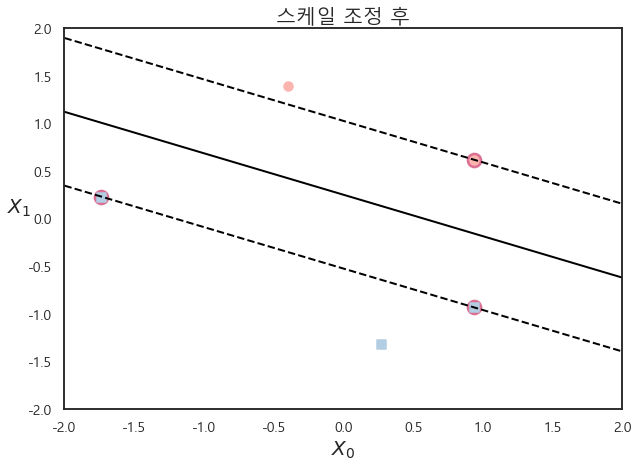

In [106]:
# Make Dataset: X는 2차원
X = np.array([[1, 50], [5, 20], [3, 80], [5, 60], [4, 10]]).astype(np.float64)
y = np.array([0, 0, 1, 1, 0])

# Scaling 수행 -> Standard Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Modeling
model_tmp2 = SVC(kernel="linear", C=100)
model_tmp2.fit(X_scaled, y)

# Plotting
plt.figure(figsize=(10,7))
w = model_tmp2.coef_[0]               # w
b = model_tmp2.intercept_[0]          # b

x0 = np.linspace(-2, 2, 200)

decision_boundary = -w[0]/w[1] * x0 - b/w[1]
margin = 1/w[1]
gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin
svs = model_tmp2.support_vectors_                    # support vectors
plt.scatter(svs[:, 0], svs[:, 1], s=200, facecolors='palevioletred')
plt.plot(x0, decision_boundary, "k-", linewidth=2)
plt.plot(x0, gutter_up, "k--", linewidth=2)
plt.plot(x0, gutter_down, "k--", linewidth=2)

plt.scatter(X_scaled[:, 0][y==1], X_scaled[:, 1][y==1], marker="o")
plt.scatter(X_scaled[:, 0][y==0], X_scaled[:, 1][y==0], marker="s")


plt.xlabel("$X_0$", fontsize=20)
plt.ylabel("$X_1$  ", fontsize=20, rotation=0)
plt.title("스케일 조정 후", fontsize=20)
plt.axis([-2, 2, -2, 2]);

In [18]:
rich.print(f'[bold]After Scaling - w: {model_tmp2.coef_[0]}, [bold]b: {model_tmp2.intercept_[0]}')

After Scaling - w: [0.56153515 1.28840986], b: -0.3250127554848994

### __<span style="color:teal">[실험 2] 결과 해석__

- 두 경우의 Hyperplane은 모두 학습 데이터를 잘 분류했기에 경험적 위험 $R_{emp}$이 0으로 동일합니다.
- 그러나 변수의 스케일을 조정하기 전 Hyperplane은 마진의 폭이 상대적으로 좁고 기울기도 다릅니다.
- 반면 변수의 스케일을 조정한 후에는 마진의 폭이 넓어지고 서포트 벡터의 수도 달라진 것을 확인하였습니다.
- 결과적으로 __<span style="color:teal">두 Case는 서로 다른  다른 Hyperplane을 가지고 있으며__, 따라서 __<span style="color:teal">변수 Scale이 달라지면 데이터 포인트가 분포하는 공간도 달라지기에, 같은 데이터에 대해서 다른 Hyperplane이 만들어지게 됩니다__.
    - 이러한 점을 유의하여서, __<span style="color:teal">SVM을 이용한 모델링을 진행할 때에는 Scaling을 수행해야 함을 실험적으로 확인__ 하였습니다.

------

위 실험을 통해 우리는 SVM 분류 모델을 구축하는 데 있어 데이터 포인트의 Scaling 여부 및 Support Vector의 영향이 매우 중요함을 확인하였습니다. 이때 Support Vector($x$)에 대한 마진은 다음과 같은 식으로 나타냅니다.
$$margin = \frac{2|f(x)|}{||w||^2} = \frac{2}{||w||^2}$$

학습 데이터를 $\mathbb{X} = \begin{Bmatrix}
(x_1, y_1), ..., (x_n, y_n)
\end{Bmatrix}$으로 표기하겠습니다. 이때 $y_i$는 분류 문제에서 Class를 의미하고, $w_1$에 속하면 $y_i=1$이고 $w_2$에 속하면 $y_i=-1$이 됩니다.   

이러한 조건에서 최대 넓이의 마진을 가지는 decision function을 찾는 것은 조건부 최적화 문제(Constrained Optimization Problem)으로 나타낼 수 있습니다. 아래 조건식에서 등호(=)가 성립하는 데이터 포인트가 바로 Support Vector입니다. 더불어 조건식은 최대 마진을 구하는 문제를 역수를 취해 최소화 하는 무제로 바꿔서 표기한 것입니다.
$$max\frac{2}{||w||} -> min\frac{1}{2}||w||^2 = min\frac{1}{2}w^T\cdot w$$
$$s.t. y_i(wTx_i+b)\geq 1 \quad i=1,...,n$$   

위의 문제를 두 가지 측면에서 보면 다음과 같습니다.
1. __Closed Form__
    - 유일 해를 가지는 경우는 $w$가 2차항만 가지게 되므로 Convex 함수가 됩니다. 조건식은 $n$개 모두 선형이므로 유일한 해를 가집니다.  
    
<br/>

2. __문제의 난이도__
    - 위 문제는 $n$개의 선형 부등식을 가진 2차 함수의 최적화 문제이며, 이때 $n$의 개수는 매우 클 수 있씁니다. 이런 경우에는 최적화 문제를  __Lagrange Problem__ 으로 접근하여 해결할 수 있습니다.

----

 ### __(참고) Lagrange Multiplier Method__   
<br/>
라그랑제 승수에 대해서 생소한 (저 같은) 사람들을 위해서, 간략한 설명을 첨언해보겠습니다. 라그랑제 승수법의 기본 개념은, 제약조건이 있는 최적화 문제에서 Objective Function 으로 제약을 옮김으로써 제약이 없는 문제로 변환하는 것입니다.   
<br/>
간단한 예를 들어볼까요? 아래와 같이 등식 제약의 조건 하에서 함수 $f(x, y)$를 최소화 하는 $x, y$를 찾아야 하는 문제가 주어졌다고 가정하겠습니다.   
$$minf(x, y) = x^2 + 2y$$
$$s.t. 3x+2y+1 = 0$$   
<br/>
이를 라그랑제 승수법을 사용하기 위해서 라그랑제 함수(Lagrangian, Lagrange function)로 정의합니다.   
<br/>
$$L(x,y,\alpha) = f(x, y) - \alpha(3x+2y+1) = x^2+2y-\alpha(3x+2y+1)$$    
<br/>
위 라그랑지안 함수 $L(\cdot)$처럼, $(\hat{x}, \hat{y})$가 제약이 있는 최적화 문제의 해라면 $(\hat{x}, \hat{y}, \hat{\alpha})$는 함수 $L(\cdot)$의 Stationary point입니다. 다시 말해 모든 편미분 함수(partial derivative)가 0인 지점이 되는 $\hat{\alpha}$가 존재하는 것입니다.  
<br/>
따라서 $x, y, \alpha$에 대한 라그랑지안 $L(\hat{x}, \hat{y}, \hat{\alpha})$의 편미분을 수행할 수 있다면 이 도함수가 모두 0이 되는 지점을 찾을 수가 있고, 제약이 있는 최적화 문제의 해는 이러한 stationary point 중에 있어야 합니다. 위 식에서 각 변수에 대해 편미분하면 아래와 같습니다.   
<br/>
$$\frac{\partial }{\partial x}L(x, y, \alpha ) = 2x-3\alpha $$
<br/>
$$\frac{\partial }{\partial y}L(x, y, \alpha ) = 2-2\alpha $$
<br/>
$$\frac{\partial }{\partial \alpha }L(x, y, \alpha ) = -3x-2y-1$$
<br/>
이때 모든 편미분 값이 0이라면, $2\hat{x}-3\hat{\alpha} = 2-2\hat{\alpha} = -3\hat{x}-2\hat{y}-1=0$ 이므로, $\hat{x}=\frac{3}{2}, \hat{y}=-\frac{11}{4}, \hat{\alpha }=1$라는 값을 계산할 수 있을 것입니다.

-------

다시 우리의 문제로 돌아와서, 라그랑제 승수법을 이용하기 위해 각 조건식마다 라그랑제 승수(Lagrange Multiplier, 보조함수) $\alpha_i$를 부여하겠습니다. 이들의 vector를 $\alpha=(\alpha_1, ..., \alpha_n)^T$로 표기합니다.
$$L(w, b, \alpha) = \frac{1}{2}||w||^2 - \sum_{i=1}^{n}\alpha _i(y_i(w^Tx_i+b)-1)$$

### __KKT(Karush-Kuhn-Tucker) Condition__

위에서 살펴본 예시는 등식 제약 조건부 최적화 문제였습니다. 하지만 SVM은 __부등식 제약(inequality constrained)__ 최적화 문제입니다. 조건에 =이 아닌 ≥가 들어가 있기 때문이죠. 이러한 문제는 아래와 같이 세 가지 KKT 조건을 이용해서 풀 수 있습니다. 이는 필요조건이기 때문에 반드시 만족해야 합니다.

<br/>

1.  __Lagrange function $L(w,b,\alpha)$에서 라그랑제 승수 $\alpha$를 제외한 $w, b$로 편미분한 식이 0이 되어야 한다.__

$$\frac{\partial L(w,b,\alpha )}{\partial w}=\frac{\partial L(w,b,\alpha )}{\partial b}=0$$

2. __모든 라그랑제 승수 $\alpha = (\alpha_1, ..., \alpha_n)^T$는 0보다 크거나 같아야 한다.__

$$\alpha_i \geq 0,\quad i = 1, ..., n$$

3. __모든 조건식에 대해서 $\alpha_i=0$이거나, $y_i(w^Tx_i+b)-1=0$이 되어야 한다.__ (이때 $y_i(w^Tx_i+b)=1$인 데이터가 Support Vector입니다.)

## 1.1.3 Wolfe Dual Problem

1.1.2에서 SVM 문제가 Convex 성질을 만족한다는 것을 알았습니다. 이러한 성질을 만족하는 조건부 최적화 문제는 Wolfe dual 문제로 변환하여 풀 수가 있습니다. 이를테면 이는 원래(Primal) 문제가 $f_i\geq 0, i=1,...,n$이라는 조건 하에 $J(\Theta )$를 최소화 하는 문제라고 했을 때, 쌍대(dual) 문제는 $\frac{\partial L (\Theta ,\alpha )}{\partial \Theta} =0$과 $\alpha_i\geq 0, i=1,...,n$ 이라는 두 가지 조건 하에서 $L(\Theta ,\alpha )=J(\Theta )-\sum_{i=1}^{n}\alpha _if_i(\Theta )$를 최대화 하는 문제로 표현할 수 있습니다. 

이를 바탕으로 원래(Primal) 라그랑지안 SVM 문제를 Dual Problem으로 나타내보겠습니다.

$$\frac{\partial L(w,b,\alpha _i)}{\partial w}=0 \quad \to \quad  w = \sum_{i=1}^{n}\alpha _iy_ix_i$$
$$\frac{\partial L(w,b,\alpha _i)}{\partial b}=0 \quad \to \quad  \sum_{i=1}^{n}\alpha _iy_i = 0$$

이제 위 식을 $L(w, b, \alpha)$에 대입하여 정리할 수 있습니다.

\begin{align} 
\frac{1}{2}||w||^2 &= \frac{1}{2}w^Tw \\
&= \frac{1}{2}w^T\sum_{j=1}^{n}\alpha_jy_jx_j \\
&= \frac{1}{2}\sum_{j=1}^{n}\alpha_jy_j(w^Tx_j) \\
&= \frac{1}{2}\sum_{j=1}^{n}\alpha_jy_j(\sum_{i=1}^{n}\alpha_iy_ix^T_ix_j) \\
&= \frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}\alpha_i\alpha_jy_iy_jx^T_ix_j
\end{align}

\begin{align} 
-\sum_{i=1}^{n}\alpha_i(y_i(w^Tx_i+b)-1) &= -\sum_{i=1}^{n}\alpha_iy_i(w^Tx_i+b) + \sum_{i=1}^{n}\alpha_i \\
&= -\sum_{i=1}^{n}\alpha_iy_iw^Tx_i - b\sum_{i=1}^{n}\alpha_iy_i+\sum_{i=1}^{n}\alpha_i \\
&= -\sum_{i=1}^{n}\sum_{j=1}^{n}\alpha_i\alpha_jy_iy_jx^T_ix_j+\sum_{i=1}^{n}\alpha_i
\end{align}

최종적인 Dual Problem은 아래와 같습니다.

$$maxL(\alpha_i)-\frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}\alpha_i\alpha_jy_iy_jx^T_ix_j \\   
s.t. \sum_{i=1}^{n}\alpha_iy_i=0 \quad \alpha_i\geq 0, \quad i=1,..., n$$

위 식은 __(1) 하나의 등식 조건과 n개의 부등식 조건을 가진 2차(quadratic) 함수의 최대화 문제__ 입니다.  
__(2) 이때 $w$와 $b$가 사라졌으므로, 라그랑제 승수 $\alpha$를 구하는 문제로 변환됩니다.__ (다시 말해, $\alpha$를 구하면 $w$와 $b$를 구할 수 있습니다.  
__(3) Objective Function에서 벡터 $x_i$가 내적 $x^T_i \cdot x_j$로 나타납니다.__ 이는 Linear SVM에서 이후 구체적으로 설명할 Kernel SVM의 개념으로 확장하는 데 결정적인 역할을 하게 됩니다.

결국 Linear SVM은 Classification에 있어 학습 데이터를 선형으로 분리할 수 있는 Decision boundary를 찾는 것이 목적이며, 이때 최적의 Decision Boundary는 데이터 클래스 간의 간격(margin)이 최대가 되는 __Maximum Marginal Hyperplane(최대 마진 초평면)__ 입니다.  
<br/>

지금까지 SVM의 이론적인 배경에 대해 알아보았으니, 본격적으로 python을 통해 구현해보겠습니다.

-------

### __<span style="color:teal">[실험 3] Binary Classification with Iris Data for Linearly Separable (Hard Margin) SVM__
1.1.3까지 확인한 SVM은 __<span style="color:teal">(1) 이진 분류일 때, (2) 선형으로 Class 별 데이터 분리가 가능(Linearly Separable)__ 하다는 전제 하에 작동하는 알고리즘에 대한 것이었습니다. 
- 따라서 실험으로 __<span style="color:teal">사용할 데이터셋은 sklearn에서 제공하는 iris 데이터셋__ 입니다.
    - 그 중에서도 __<span style="color:teal">꽃잎의 길이와 너비만을 이용하여 Versicolor와 Setosa를 구분__ 할 수 있는지 여부를 확인할 것입니다. 
    - 해당 데이터셋은 __선형 분리가 가능한 이진 분류 문제__ 로 알려져 있기 때문에 예제 데이터로서 채택하였습니다.  
    - 관측치가 100개밖에 되지 않는 데이터이기에, Train/Test를 분리하기 보다 __K-fold Cross Validation을 통해 학습 데이터와 평가 데이터를 분리__ 하였습니다.
<br/>

참고로 실제 현실 세계의 데이터는 __선형의 직선__ 만으로 __데이터 포인트를 모두 완벽히 분류__ 하기는 어렵습니다. 이때 __마진을 넘어가는 이상치를 어떻게 처리할 수 있을지__ , 그리고 __선형으로 데이터 분류가 되지 않는 경우에는 어떻게 할 수 있을 지__ 에 대해서는 아래에 좀 더 자세히 다루어 보겠습니다.

- 먼저 데이터셋을 load 합니다. `scikit-learn`의 `datasets` 라이브러리 내에서 불러올 수 있는 유명 데이터셋이며, 꽃잎의 길이와 너비만을 이용하여 이진 분류를 수행할 것입니다. 분류 Class는 iris가 setosa인지, versicolor인지를 구분하는 것입니다.

In [122]:
iris_data = datasets.load_iris()
X = iris_data["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris_data["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [123]:
# Train Test Split
kfold = KFold(n_splits=5, shuffle=True, random_state=2022)

In [314]:
# SVM 분류 모델 (C는 hyperparameter로, 이 의미에 대해서는 아래 soft margin svm 파트에서 추가적으로 설명할 것입니다.)
iris_model = SVC(kernel='linear', C=float("inf"))

# 결과 확인
rich.print(f'[bold] Stratified Cross-validation scores with default hard margin svm, {cross_val_score(iris_model, X, y, cv=kfold, scoring="roc_auc").mean()}')

 Stratified Cross-validation scores with default hard margin svm, 1.0

- 모델은 `scikit-learn`의 `svm` 클래스에서 제공하는 `SVC`는 Support Vector Classification을 이용하였습니다. 모델을 호출할 시 사용할 수 있는 파라미터 중 본 튜토리얼에서 실험을 통해 바꾸어 볼 목록은 아래와 같습니다.
|Parameters|Type|Default|Description|
|------|---|---|:---:|
|__C__|float|1.0|Regularization parameter입니다. 값이 커질 수록 마진을 벗어나는 noise에 대해서 규제를 강하게 한다는 의미입니다.|
|__kernel__|str|'rbf'|어떤 kernels을 이용하여 SVM 알고리즘을 설계할 지를 결정하는 인자입니다. 이때 kernel이란 무엇인지에 대해서는 추후 다룰 것이며, 'linear' 옵션을 줄 경우에는 선형 분리를 통해 클래스를 분류합니다.|
|__class_weight__|dict or 'balanced'|None|C 파라미터에 대해서, `class_weight`* C의 형태로 연산됩니다. 클래스 불균형일 경우에 사용하며, 적절한 가중치는 `n_samples / (n_classes * np.bincount(y))`로 계산합니다. 만일 None일 경우 모든 class가 동일한 가중치를 가지게 됩니다.|

<br/>

- 위 Hyperparameter가 바뀔 때 SVC의 결과에 대해 확인하기 위하여, C 값은 모든 데이터가 선형 분리되는 경우를 가정하여 매우 강한 규제를 두었고, kernel은 'linear'로, 그리고 나머지는 default 값으로 세팅하였습니다.
    - 만일 데이터가 선형 분리되지 않는 경우에, C라는 penalty term의 차이에 따라 어떻게 모델의 Decision Boundary가 바뀌는 지 아래에 좀 더 자세히 다루겠습니다.

<br/>

- 이때 `scikit-learn`의 `SVC` 클래스에서 제공하는 attribute 중 `coef_`, `intercept_`, `support_vectors_`가 있습니다.
    - `coef_`: Primal Problem을 푸는 데 있어서의 coefficient, 즉 features의 가중치를 의미합니다. (n_classes * (n_classes - 1) / 2, n_features)로 계산됩니다.
    - `intercept_`: Decision function의 y 절편입니다.
    - `support_vectors_`: Margin 형성에 기여하는 Support Vectors를 반환합니다.
    
    <br/>
    
- 위 세 가지 attributes를 이용하여 아래와 같이 시각화를 수행하고, 모델의 분류 결과를 확인해보겠습니다.

In [125]:
# 결과 확인
rich.print(f'[bold] Stratified Cross-validation AUROC scores with default heard margin svm, {cross_val_score(iris_model, X, y, cv=kfold, scoring="roc_auc").mean()}')

 Stratified Cross-validation AUROC scores with default heard margin svm, 1.0

- 확인 결과 Setosa와 Versicolor를 구분하는 이진 분류 문제에서는, <__span style="color:teal">기본적인 default hyperparameter 만으로도 ROC_AUC Socre가 평균 1.0이 나온 우수한 성능</span>__ 을 보였습니다.
- 즉, __<span style="color:teal">데이터가 선형으로 잘 분리__ 가 되며, __<span style="color:teal">이를 구분할 수 있는 Hyperplane을 쉽게 찾을 수 있다는 의미__ 입니다.
- 정말 그러한 지를 시각적으로도 확인해보겠습니다.

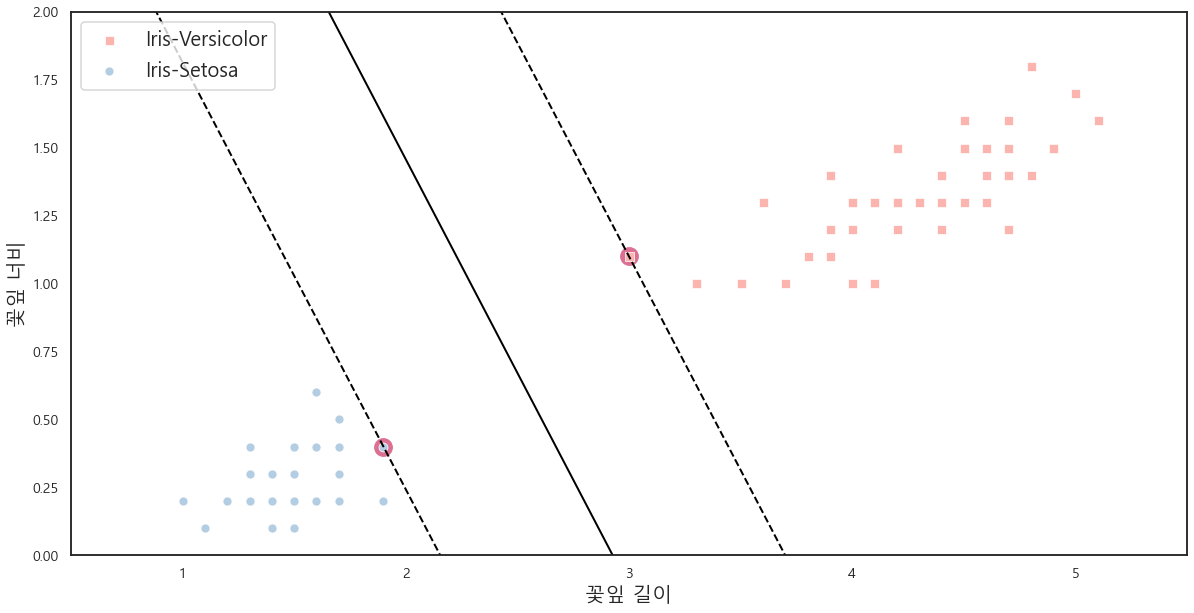

In [126]:
plt.figure(figsize=(20, 10))

iris_model.fit(X, y)

w = iris_model.coef_[0]        # Weights assigned to the features (coefficients in the primal problem).
b = iris_model.intercept_[0]   # Constants in decision function.

x0 = np.linspace(0, 5.5, 200)
decision_boundary = -w[0]/w[1] * x0 - b/w[1]

margin = 1/w[1]
gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin

svs = iris_model.support_vectors_  # support vectors
plt.scatter(svs[:, 0], svs[:, 1], s=300, facecolors='palevioletred')
plt.plot(x0, decision_boundary, "k-", linewidth=2)
plt.plot(x0, gutter_up, "k--", linewidth=2)
plt.plot(x0, gutter_down, "k--", linewidth=2)

sns.scatterplot(X[:, 0][y==1], X[:, 1][y==1], marker="s", label="Iris-Versicolor")
sns.scatterplot(X[:, 0][y==0], X[:, 1][y==0], marker="o", label="Iris-Setosa")
plt.xlabel("꽃잎 길이", fontsize=20)
plt.ylabel("꽃잎 너비", fontsize=20)
plt.legend(loc="upper left", fontsize=20)
plt.axis([0.5, 5.5, 0, 2])

plt.show();

- 확인 결과 __<span style="color:teal">Default Hyperparameter 만으로도 margin이 넓고 모든 데이터를 잘 분류하는 Hyperplane을 찾았음을 시각적으로도 확인__ 하였습니다. 이때 __<span style="color:palevioletred">분홍색으로 강조</span>된 데이터 포인트가 바로 해당 모형의 <span style="color:palevioletred">Support Vector</span>__ 입니다.

-----

### __<span style="color:teal">[실험 4] Deal with Class Imbalanced Problem in (Hard Margin) SVM__

Iris dataset은 클래스 당 관측치 개수가 균일한 이상적인 데이터셋입니다. 하지만 __실제 현실 세계에서는 클래스 비율이 불균형한 경우__ 가 빈번합니다. 이러한 경우에는 Hyperplane가 제대로 형성되지 않을 가능성이 높습니다.   
앞서 우리는 `SVC` Class에 `class_weight` 파라미터가 있는 것을 확인하였습니다. 이는 클래스 불균형 상황을 반영하는 것이며, __<span style="color:teal">예제를 통해 불균형 상황을 고려한 경우와 고려하지 않은 경우에 대해 구분하여 살펴보겠습니다.__

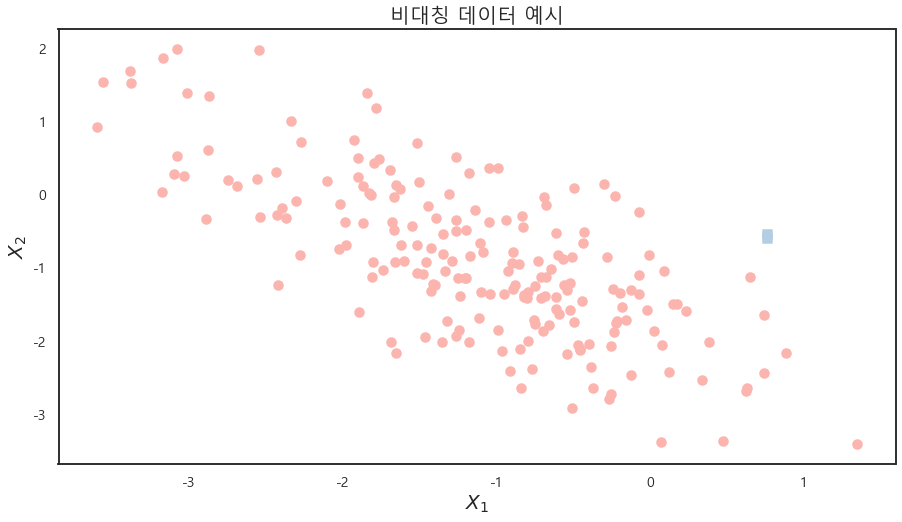

In [223]:
plt.figure(figsize=(15, 8))
plt.title("비대칭 데이터 예시", fontsize=20)

X, y = make_classification(n_samples=200, n_features=2, n_informative=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99, 0.01], random_state=4
                          )

plt.scatter(X[:, 0][y==0], X[:, 1][y==0], marker="o")
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], marker="s")

plt.xlabel("$X_1$", fontsize=20)
plt.ylabel("$X_2$", fontsize=20)
plt.show();

- 위 데이터는 __클래스 별 데이터 개수가 99:1인 경우를 상정한 가상 데이터셋__ 입니다. 이러한 경우에는 `class_weight` 파라미터 값을 'balanced'로 주어 이를 반영할 수가 있습니다.

### __<span style="color:teal">Case 1: 클래스 불균형을 고려하지 않은 경우__

In [226]:
model_imbalance = SVC(kernel='linear', class_weight=None, C=float("inf"))

# 결과 확인
rich.print(f'[bold] Stratified Cross-validation Accuracy scores with Hard margin svm (no class weight), {cross_val_score(model_imbalance_C1, X, y, cv=kfold, scoring="balanced_accuracy").mean()}')

 Stratified Cross-validation Accuracy scores with Hard margin svm (no class weight), 0.8

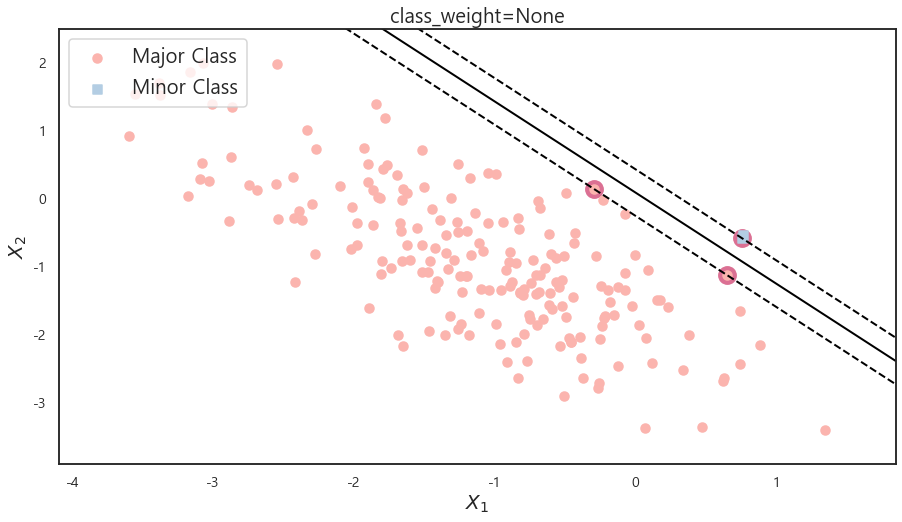

In [202]:
model_imbalance.fit(X, y)

plt.figure(figsize=(15, 8))

w = model_imbalance.coef_[0]        # Weights assigned to the features (coefficients in the primal problem).
b = model_imbalance.intercept_[0]   # Constants in decision function.

x0 = np.linspace(np.min(X[:, 0])-0.5, np.max(X[:, 0])+0.5, 200)
decision_boundary = -w[0]/w[1] * x0 - b/w[1]

margin = 1/w[1]
gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin

svs = model_imbalance.support_vectors_  # support vectors
plt.scatter(svs[:, 0], svs[:, 1], s=300, facecolors='palevioletred')

plt.plot(x0, decision_boundary, "k-", linewidth=2)
plt.plot(x0, gutter_up, "k--", linewidth=2)
plt.plot(x0, gutter_down, "k--", linewidth=2)

plt.scatter(X[:, 0][y==0], X[:, 1][y==0], marker="o", label="Major Class")
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], marker="s", label="Minor Class")

plt.title("class_weight=None", fontsize=20)
plt.xlabel("$X_1$", fontsize=20)
plt.ylabel("$X_2$", fontsize=20)
plt.legend(loc="upper left", fontsize=20)
plt.axis([np.min(X[:, 0])-0.5, np.max(X[:, 0])+0.5, np.min(X[:, 1])-0.5, np.max(X[:, 1])+0.5])

plt.show();

### __<span style="color:teal">Case 2: 클래스 불균형을 고려한 경우__

In [227]:
model_balance = SVC(kernel='linear', class_weight='balanced', C=float("inf"))

# 결과 확인
rich.print(f'[bold] Stratified Cross-validation Accuracy scores with Hard margin svm (balanced class weight), {cross_val_score(model_imbalance_C1, X, y, cv=kfold, scoring="balanced_accuracy").mean()}')

 Stratified Cross-validation Accuracy scores with Hard margin svm (balanced class weight), 0.8

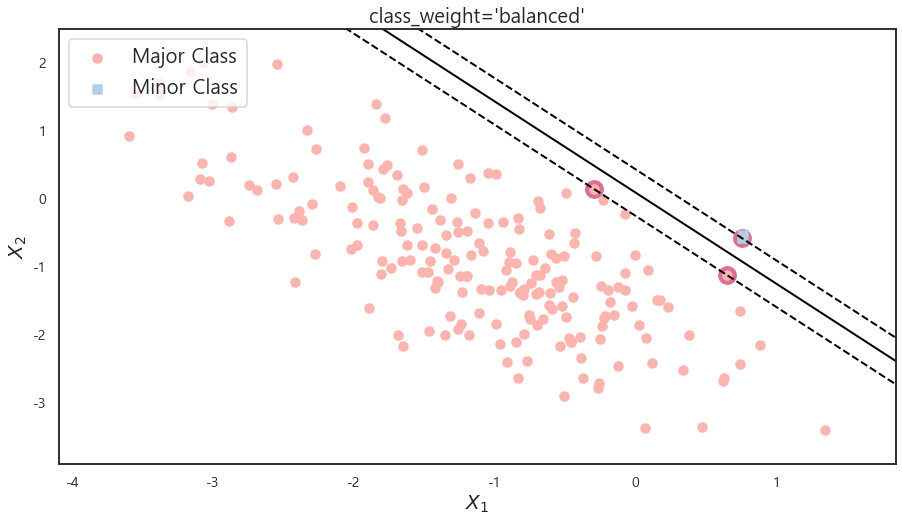

In [203]:
model_balance.fit(X, y)

plt.figure(figsize=(15, 8))

w = model_balance.coef_[0]        # Weights assigned to the features (coefficients in the primal problem).
b = model_balance.intercept_[0]   # Constants in decision function.

x0 = np.linspace(np.min(X[:, 0])-0.5, np.max(X[:, 0])+0.5, 200)
decision_boundary = -w[0]/w[1] * x0 - b/w[1]

margin = 1/w[1]
gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin

svs = model_balance.support_vectors_  # support vectors
plt.scatter(svs[:, 0], svs[:, 1], s=300, facecolors='palevioletred')

plt.plot(x0, decision_boundary, "k-", linewidth=2)
plt.plot(x0, gutter_up, "k--", linewidth=2)
plt.plot(x0, gutter_down, "k--", linewidth=2)

plt.scatter(X[:, 0][y==0], X[:, 1][y==0], marker="o", label="Major Class")
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], marker="s", label="Minor Class")

plt.title("class_weight='balanced'", fontsize=20)
plt.xlabel("$X_1$", fontsize=20)
plt.ylabel("$X_2$", fontsize=20)
plt.legend(loc="upper left", fontsize=20)
plt.axis([np.min(X[:, 0])-0.5, np.max(X[:, 0])+0.5, np.min(X[:, 1])-0.5, np.max(X[:, 1])+0.5])

plt.show();

- 확인 결과 __<span style="color:teal">Decision Boundary에 큰 차이가 없는 것__ 을 시각적으로 확인하였습니다.
- 더불어 __<span style="color:teal">데이터 불균형 상황을 고려하여 'Balanced Accuracy'를 이용하여 산출하였을 때, 모두 0.8로 동일한 성능을 보였음을 확인하였습니다.__

    <br/>
    
- 따라서 `SVC`에서 제공하는 attribute인 `class_weight_`를 통해서 각 클래스 별로 곱해진 가중치에 차이가 있는 지를 확인해보았습니다.

In [109]:
rich.print(f'When class_weight = [bold]None: {model_imbalance.class_weight_}')
rich.print(f'When class_weight = [bold]`balanced`: {model_balance.class_weight_}')

When class_weight = None: [1. 1.]

When class_weight = `balanced`: [ 0.50505051 50.        ]

### __<span style="color:teal">[실험 4] 결과 해석__
- Class weight을 고려하지 않은 경우는 가중치가 모두 1로 동일하지만, __Class weight을 'balanced'로 맞춘 경우에는 Major Class의 경우 0.51, Minor Class의 경우에는 50으로 상이하게 차이가 나는 것을 확인__ 하였습니다.
    
- 그럼에도 __<span style="color:teal">Decision Function에 차이가 나지 않는 이유__ 는, [공식 홈페이지](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)에 따르면 __<span style="color:teal">`class_weight`이 파라미터 `C`에 곱해지는 가중치__ 이기 때문입니다. 그러나 __<span style="color:teal">위 케이스의 경우 C의 값을 inf로 주었기 때문에, 가중치 반영이 되지 않았던 것__ 입니다. 
    
- 더불어 선형 decision boundary로 구분이 가능한 Hard Margin Case이기에 Hyperplane에 큰 차이가 없을 것이라는 결론을 내렸습니다.

    <br/>
    
- 그렇다면 C는 언제 사용되는 Hyperparameter 일까요?

-----------

## 1.2 Linear SVM Classification (Soft Margin)
앞서 살펴본 SVM 방식은 __Hard Margin SVM__ 이라 하여, 매우 엄격하게 두 개의 Class를 분리하는 Hyperplane을 구하는 방법입니다. __Hard Margin에서 모든 학습 데이터는 Hyperplane을 사이에 두고 무조건 하나의 Class에 속해야 합니다__

<br/>

하지만, 아래의 예제에서도 알 수 있듯이 __<span style="color:crimson">데이터에 이상치나 노이즈가 섞일 경우에는 두 클래스를 분류하는 Hyperplane을 구할 수 없거나 제대로 구하지 못할 수도 있습니다.__

### __<span style="color:teal">[예제] Hard Magin SVM이 불가능한 경우__

In [111]:
X, y = make_classification(n_samples=100, n_features=2, n_informative=1, n_redundant=0,
                           n_clusters_per_class=1, random_state=4)

model_ex = SVC(kernel='linear', C=10**9)
model_ex.fit(X, y)

SVC(C=1000000000, kernel='linear')

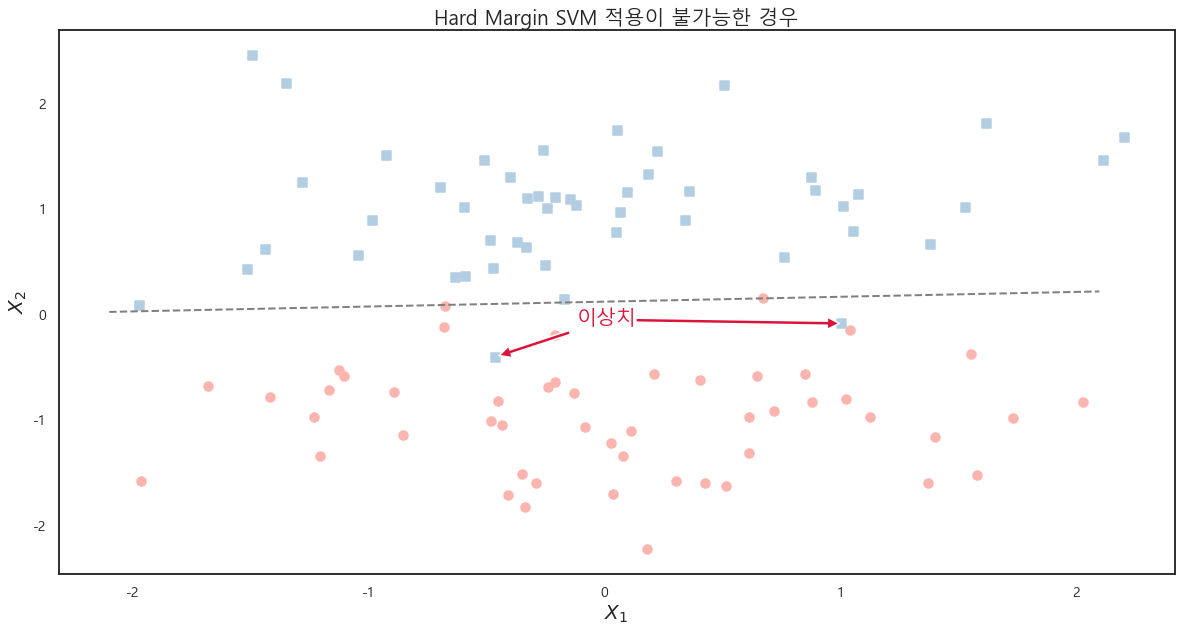

In [113]:
plt.figure(figsize=(20, 10))

plt.title("Hard Margin SVM 적용이 불가능한 경우", fontsize=20)

plt.scatter(X[:, 0][y==0], X[:, 1][y==0], marker="o")
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], marker="s")

w = model_ex.coef_[0]
b = model_ex.intercept_[0]

x0 = np.linspace(-2.1, 2.1, 500)
decision_boundary = -w[0]/w[1] * x0 - b/w[1]

plt.plot(x0, decision_boundary, color="gray", ls="--", linewidth=2)


anomaly1 = X[np.where(X[:, 1] == np.min(X[:, 1][y==1]))[0][0]]
anomaly2 = X[y==1][np.where(X[:, 1][y==1] < 0)[0][0]]

plt.annotate("이상치",
             xy=tuple(anomaly1),
             xytext=(0.01, -0.1),
             ha="center",
             arrowprops=dict(facecolor='crimson', shrink=0.05),
             fontsize=20,
             color = 'crimson'
            )
plt.annotate(" ", 
             xy=tuple(anomaly2), 
             xytext=(0.1, -0.1),
             ha="center",
             arrowprops = dict(facecolor='crimson', shrink=0.01)
            )

plt.xlabel("$X_1$", fontsize=20)
plt.ylabel("$X_2$", fontsize=20)
plt.show();

<span style="color:crimson">위와 같은 문제를 해결하기 위해서 개발된 방법론이 __Soft Margin SVM__</span> 입니다. Soft Margin SVM은 기본적으로 Hard Margin 방법을 기반으로 하지만, 가장 큰 차이점은 아래의 그림처럼 __Support Vectors가 위치한 경계선에 약간의 여유 변수(Slack Variable, $\xi $)을 두는 것__ 입니다.

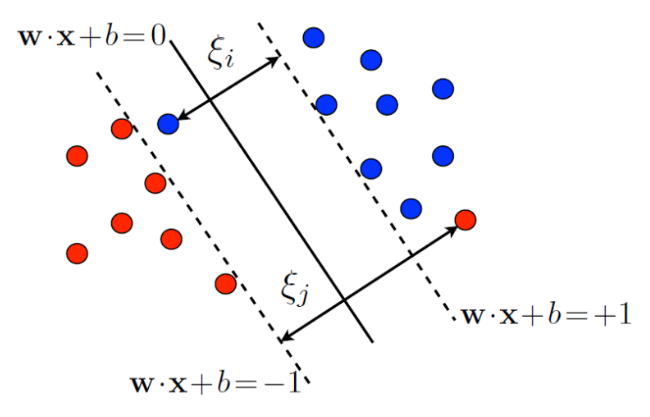

Scikit-Learnin의 SVM 모델에서는 이러한 여유 변수를 `C`라는 Hyperparameter로 제공하고 있으며, `C`는 __마진의 평면을 넘어가는 관측치에 대해서 부여하는 penalty로 작용__ 합니다. 기본적으로 __속한 Class의 마진 평면에서 떨어진 거리만큼 부여__ 됩니다.

## 1.2.1 Soft Margin SVM의 Objective Function

이처럼 여유 변수 $\xi$를 추가한 Soft Margin SVM의 목적함수는 다음과 같습니다.
$$min\frac{1}{2}||w||^2+C\sum_{i=1}^{m}\xi_i$$
$$s.t. \quad y_i(w^Tx_i+b)\geq 1-\xi_i \quad i=1,..., n, \quad \xi_i\geq0$$

<br/>

위 식은 __<span style="color:crimson">Margin을 최대한 크게 하는 동시에 $\xi>0$인 데이터의 수를 최소한으로 하는 Hyperplane의 방향 $w$를 찾자__ 는 의미로 해석할 수 있습니다.

여기서 __`C`__ 가 등장합니다. C는 마진의 평면을 넘어가는 데이터를 합한 것에 곱해지는 일종의 __penalty__ 입니다.
> - __<span style="color:midnightblue">`C`를 작게 한다는 것__ 은 __<span style="color:midnightblue">마진을 나타내는 첫번 째 항 $(\frac{1}{2}||w||^2)$을 중요하게 생각하는 것, 즉 에러를 너그럽게 허용하며 마진을 넓히고자 하는 것__ 으로 볼 수 있습니다.
> - __<span style="color:indianred">`C`를 크게 한다는 것__ 은 __<span style="color:indianred">에러를 최소화 하고자 하며, 마진 사이에 존재하는 데이터나 이상치의 수를 줄이겠다__ 는 의미로 해석할 수 있습니다. 따라서 마진의 넓이가 작아지겠죠.
    - 우리가 `SVM` 클래스를 이용하여 __Hard Margin SVM을 구현하고자 할 때, Hyperparameter인 C의 값을 +inf으로 둔 이유__ 가 바로 여기에 있습니다.

그리고 Soft Margin SVM은 어느 정도의 오류를 포함하기 때문에, 이를 Objective Function을 이용하여 최적화 할 수 있습니다. 제약식 $\quad y_i(w^Tx_i+b)\geq 1-\xi_i$를 아래와 같이 다시 나타내보겠습니다.

<br/>

$$\xi_i = max(0, 1-y_i(w^Tx_i+b))$$

<br/>

위 식을 Objective Function의 측면에서 보면, 다음과 같이 목적함수를 정의할 수 있을 것입니다.

<br/>

$$J(w, b) = \frac{1}{2}||w||^2+C\sum_{i=1}^{n}max(0, 1-y_i(w^Tx_i+b))$$

위와 같은 $max(0, 1-y)$의 형태를 __Hinge Loss__ 함수라고 합니다. 이진 분류에서 Hinge Loss는 $Loss = max(0, 1-(y'*y))$로 정의되며, 여기서 $y$는 실제 레이블(-1 또는 1)이며 $y'$는 Classifier의 출력 결과입니다.
- 이때 Hinge Loss와 $(y * y')$로 그래프를 그리면 아래와 같은 형태가 됩니다.
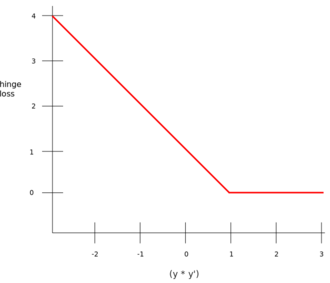

------

### __<span style="color:teal">[실험 5] Binary Classification with Iris Data for Linearly Separable Soft Margin SVM__
__C 값의 변화에 따른 Hyperplane 및 성능 차이 비교__

- [실험 3]과 동일한 데이터셋을 사용하겠습니다. 마찬가지로 Binary Classification 상황을 고려하여 데이터셋을 변형하려 합니다.
- 이번에는 iris 데이터가 Virginca에 속하면 1, 그렇지 않으면 0인 이진 분류 문제에 대해서 풀어보고자 합니다.

- 모델을 호출할 시 사용할 수 있는 파라미터 중 본 튜토리얼에서 실험을 통해 바꾸어 볼 목록에 대해 다시 상기하겠습니다.
|Parameters|Type|Default|Description|
|------|---|---|:---:|
|__C__|float|1.0|Regularization parameter입니다. 값이 커질 수록 마진을 벗어나는 noise에 대해서 규제를 강하게 한다는 의미입니다.|
|__kernel__|str|'rbf'|어떤 kernels을 이용하여 SVM 알고리즘을 설계할 지를 결정하는 인자입니다. 이때 kernel이란 무엇인지에 대해서는 추후 다룰 것이며, 'linear' 옵션을 줄 경우에는 선형 분리를 통해 클래스를 분류합니다.|
|__class_weight__|dict or 'balanced'|None|C 파라미터에 대해서, `class_weight`* C의 형태로 연산됩니다. 클래스 불균형일 경우에 사용하며, 적절한 가중치는 `n_samples / (n_classes * np.bincount(y))`로 계산합니다. 만일 None일 경우 모든 class가 동일한 가중치를 가지게 됩니다.|

<br/>

- 이때 Hard Margin과는 다르게, __<span style="color:teal">Soft Margin에서 자유롭게 바꿀 수 있는 파라미터는 `C`__ 입니다. __<span style="color:teal">노이즈가 섞여 있는 경우, 해당 데이터를 얼마만큼의 penalty를 통해 규제할 지를 지정해야 하는 것__ 입니다.

<br/>
    
- 따라서 [실험 5]에서는 __<span style="color:teal">C 값의 변화에 따른 Hyperplane 및 성능 차이를 비교__ 해보겠습니다.
    - Hyperplane의 경우 시각화를 통해 차이를 구분해보려 합니다.

In [205]:
iris = datasets.load_iris()
X = iris['data'][:, (2, 3)]  # petal length, petal width
y = (iris['target'] == 2).astype(np.float64)  # Iris - Virginca라면 1 아니면 0

- 앞서 __SVM은 Feature들의 Scale에 매우 민감하게 반응한다는 것을 선행적으로 확인__ 하였습니다. 따라서 [실험 5]에서는 Feature Scaling을 수행하여 분류를 수행합니다.

In [206]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

- 앞선 과정을 거친 결과, 최종적인 X 데이터는 아래와 같이 시각화 할 수 있습니다.
    - 확인 결과 __<span style="color:teal">Class 간에 데이터 포인트가 완전히 구분되지 않고</span>, <span style="color:indianred">일정 부분의 노이즈</span>가 있는 것을 확인하였습니다.__
    - 이를 __<span style="color:teal">Soft Margin SVM을 이용하여 풀어보겠습니다.__

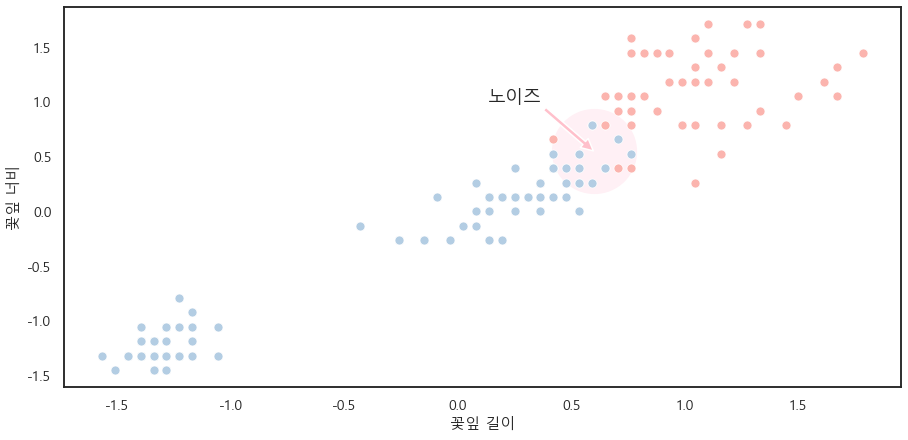

In [207]:
plt.figure(figsize=(15,7))
plt.scatter(x=0.6, y=0.55, s=7000, facecolor='lavenderblush')
plt.annotate("노이즈", 
             xy=(0.6, 0.55), 
             xytext=(0.25, 1.0),
             ha="center",
             arrowprops = dict(facecolor='pink', shrink=0.01)
            )
sns.scatterplot(X_scaled[:, 0][y==1], X_scaled[:, 1][y==1])
sns.scatterplot(X_scaled[:, 0][y==0], X_scaled[:, 1][y==0]);
plt.xlabel("꽃잎 길이", fontsize=15)
plt.ylabel("꽃잎 너비", fontsize=15);

- 마찬가지로 데이터 수가 100개인 작은 데이터셋이기 때문에, K-Fold Cross Validation을 수행하였습니다.
    - K의 개수는 5개로 지정하였습니다.

In [208]:
# Train Test Split
kfold = KFold(n_splits=5, shuffle=True, random_state=2022)

### __<span style="color:teal"> Case 1: C=1.0__

In [209]:
iris_model_1 = SVC(kernel='linear', C=1.0)

# 결과 확인
# 결과 확인
rich.print(f'[bold] Stratified Cross-validation AUROC scores with soft margin svm (C=1.0), {cross_val_score(iris_model_1, X_scaled, y, cv=kfold, scoring="roc_auc").mean()}')
rich.print(f'[bold] Stratified Cross-validation Accuracy with soft margin svm (C=1.0), {cross_val_score(iris_model_1, X_scaled, y, cv=kfold, scoring="accuracy").mean()}')

 Stratified Cross-validation AUROC scores with soft margin svm (C=1.0), 0.9972222222222221

 Stratified Cross-validation Accuracy with soft margin svm (C=1.0), 0.9533333333333334

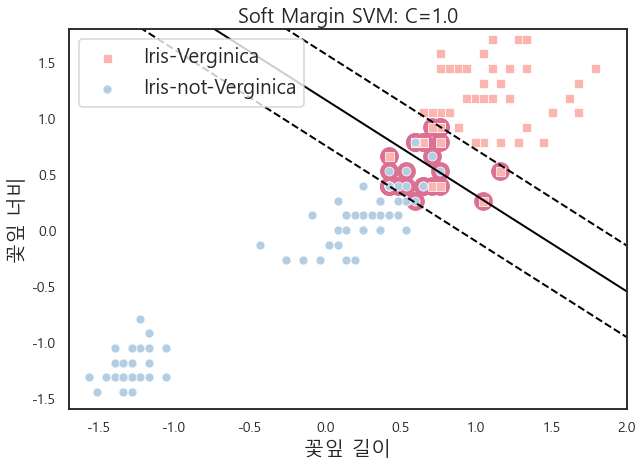

In [211]:
plt.figure(figsize=(10, 7))

iris_model_1.fit(X_scaled, y)

w = iris_model_1.coef_[0]        # Weights assigned to the features (coefficients in the primal problem).
b = iris_model_1.intercept_[0]   # Constants in decision function.

x0 = np.linspace(-2, 2, 200)
decision_boundary = -w[0]/w[1] * x0 - b/w[1]

margin = 1/w[1]
gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin

svs = iris_model_1.support_vectors_  # support vectors
plt.scatter(svs[:, 0], svs[:, 1], s=300, facecolors='palevioletred')
plt.plot(x0, decision_boundary, "k-", linewidth=2)
plt.plot(x0, gutter_up, "k--", linewidth=2)
plt.plot(x0, gutter_down, "k--", linewidth=2)

sns.scatterplot(X_scaled[:, 0][y==1], X_scaled[:, 1][y==1], marker="s", label="Iris-Verginica")
sns.scatterplot(X_scaled[:, 0][y==0], X_scaled[:, 1][y==0], marker="o", label="Iris-not-Verginica")
plt.title("Soft Margin SVM: C=1.0", fontsize=20)
plt.xlabel("꽃잎 길이", fontsize=20)
plt.ylabel("꽃잎 너비", fontsize=20)
plt.legend(loc="upper left", fontsize=20)
plt.axis([-1.7, 2, -1.6, 1.8])

plt.show();

### __<span style="color:teal">Case 2: C=100.0__

In [30]:
iris_model_100 = SVC(kernel='linear', C=100.0)

# 결과 확인
rich.print(f'[bold] Stratified Cross-validation AUROC scores with soft margin svm (C=100.0), {cross_val_score(iris_model_100, X_scaled, y, cv=kfold, scoring="roc_auc").mean()}')
rich.print(f'[bold] Stratified Cross-validation Accuracy with soft margin svm (C=100.0), {cross_val_score(iris_model_100, X_scaled, y, cv=kfold, scoring="accuracy").mean()}')

 Stratified Cross-validation AUROC scores with soft margin svm (C=100.0), 0.9972222222222221

 Stratified Cross-validation Accuracy with soft margin svm (C=100.0), 0.96

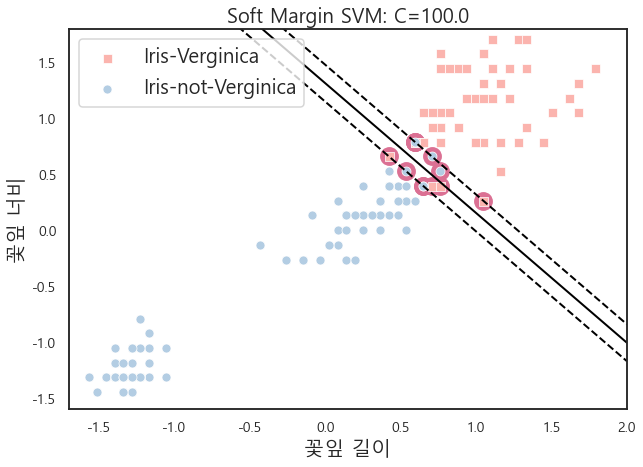

In [34]:
plt.figure(figsize=(10, 7))

iris_model_100.fit(X_scaled, y)

w = iris_model_100.coef_[0]        # Weights assigned to the features (coefficients in the primal problem).
b = iris_model_100.intercept_[0]   # Constants in decision function.

x0 = np.linspace(-2, 2, 200)
decision_boundary = -w[0]/w[1] * x0 - b/w[1]

margin = 1/w[1]
gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin

svs = iris_model_100.support_vectors_  # support vectors
plt.scatter(svs[:, 0], svs[:, 1], s=300, facecolors='palevioletred')
plt.plot(x0, decision_boundary, "k-", linewidth=2)
plt.plot(x0, gutter_up, "k--", linewidth=2)
plt.plot(x0, gutter_down, "k--", linewidth=2)

sns.scatterplot(X_scaled[:, 0][y==1], X_scaled[:, 1][y==1], marker="s", label="Iris-Verginica")
sns.scatterplot(X_scaled[:, 0][y==0], X_scaled[:, 1][y==0], marker="o", label="Iris-not-Verginica")
plt.title("Soft Margin SVM: C=100.0", fontsize=20)
plt.xlabel("꽃잎 길이", fontsize=20)
plt.ylabel("꽃잎 너비", fontsize=20)
plt.legend(loc="upper left", fontsize=20)
plt.axis([-1.7, 2, -1.6, 1.8])

plt.show();

### __<span style="color:teal">Case 3: C = 1000000.0__

In [31]:
iris_model_largeC = SVC(kernel='linear', C=10**6)

# 결과 확인
rich.print(f'[bold] Stratified Cross-validation AUROC scores with soft margin svm (C=1000000.0), {cross_val_score(iris_model_largeC, X_scaled, y, cv=kfold, scoring="roc_auc").mean()}')
rich.print(f'[bold] Stratified Cross-validation Accuracy with soft margin svm (C=1000000.0), {cross_val_score(iris_model_largeC, X_scaled, y, cv=kfold, scoring="accuracy").mean()}')

 Stratified Cross-validation AUROC scores with soft margin svm (C=1000000.0), 0.9972222222222221

 Stratified Cross-validation Accuracy with soft margin svm (C=1000000.0), 0.96

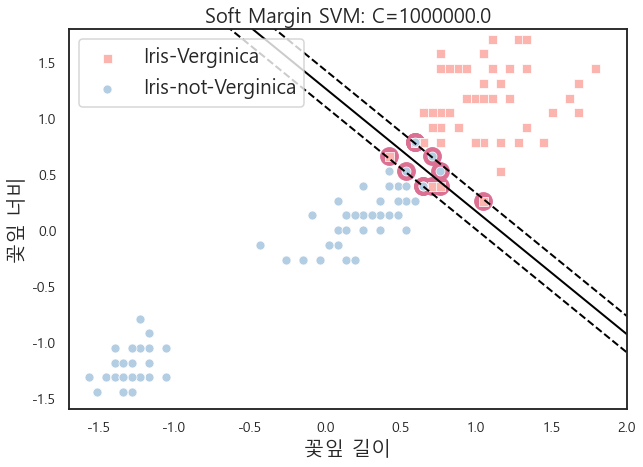

In [35]:
plt.figure(figsize=(10, 7))

iris_model_largeC.fit(X_scaled, y)

w = iris_model_largeC.coef_[0]        # Weights assigned to the features (coefficients in the primal problem).
b = iris_model_largeC.intercept_[0]   # Constants in decision function.

x0 = np.linspace(-2, 2, 200)
decision_boundary = -w[0]/w[1] * x0 - b/w[1]

margin = 1/w[1]
gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin

svs = iris_model_largeC.support_vectors_  # support vectors
plt.scatter(svs[:, 0], svs[:, 1], s=300, facecolors='palevioletred')
plt.plot(x0, decision_boundary, "k-", linewidth=2)
plt.plot(x0, gutter_up, "k--", linewidth=2)
plt.plot(x0, gutter_down, "k--", linewidth=2)

sns.scatterplot(X_scaled[:, 0][y==1], X_scaled[:, 1][y==1], marker="s", label="Iris-Verginica")
sns.scatterplot(X_scaled[:, 0][y==0], X_scaled[:, 1][y==0], marker="o", label="Iris-not-Verginica")
plt.title("Soft Margin SVM: C=1000000.0", fontsize=20)
plt.xlabel("꽃잎 길이", fontsize=20)
plt.ylabel("꽃잎 너비", fontsize=20)
plt.legend(loc="upper left", fontsize=20)
plt.axis([-1.7, 2, -1.6, 1.8])

plt.show();

### __<span style="color:teal">[실험 5] 결과 해석__
- C 값을 1.0, 100.0, 1000000.0으로 바꾸어가며 Hyperplane 및 성능을 확인해본 결과,
    1. Hyperplane의 경우 __<span style="color:teal">C의 값이 커지면 margin이 좁아지는 것을 확인__ 하였습니다. 이는 __C가 작을 수록 error를 너그럽게 허용하기 때문입니다. 즉, margin 평면을 벗어나는 것을 허용하기에 넓은 margin의 hyperplane이 형성되는 것__ 이죠.
    
    <br/>
    
    2. 성능의 경우 __C의 값을 변화시키더라도 AUROC 값이 모두 0.9972로 동일__ 하였으나, __Accuracy는 C=1.0이 0.95, C가 100 이상인 경우는 0.96을 보이며 약간의 차이를 확인__ 할 수 있었습니다.
        - 이는 __<span style="color:teal">C의 값이 클 수록 어떻게든 데이터 클래스를 분류하고자 하는 성질 때문이며, error를 허용하지 않기에 미세하게나마 높은 성능__ 을 보일 수 있는 것입니다.
    
    <br/>
    
    3. 또한 C가 100인 경우와 100000인 경우는  hyperplane이 시각적으로도 동일하였기에, __어느 정도의 성능을 확인한 이후에는 상대적으로 작은 C의 값을 찾는 것이 바람직__ 해 보입니다. 이는 __C가 커질 수록 error를 줄이기 위해 연산량이 더 높아지기에 train cost가 함께 높아지는 부분을 고려한 것__ 입니다.

    <br/>
    
- 하지만 본 실험에서의 데이터셋은 적은 수의 관측치를 가진 toy dataset이며, 실제 현실 데이터셋에서는 C가 클 수록 train error는 작아지지만 test error는 높아지며 geenralization에 대한 문제가 발생할 수 있습니다.

------

### __<span style="color:teal">[실험 6] Deal with Class Imbalanced Problem in Soft Margin SVM__

앞선 __<span style="color:teal">[실험 4]에서 우리는 클래스 당 관측치 개수가 상이한 불균형 데이터셋에 대한 실험을 진행__  한 바 있습니다. 이러한 경우 `SVC` class의 `class_weight` 파라미터에 'balanced' 값을 주어 불균형 상황을 반영할 수 있습니다.   
    더불어 __이 가중치 값은 C와 곱해지는 것__ 이기에, __<span style="color:teal">[실험 4]의 Hard Margin SVM Case와는 달리, Soft Margin SVM Case에서는 `class_weight` 인자 값에 따른 성능 차이가 있을 것이라는 가설__ 하에, 다음과 같은 실험을 진행하였습니다.

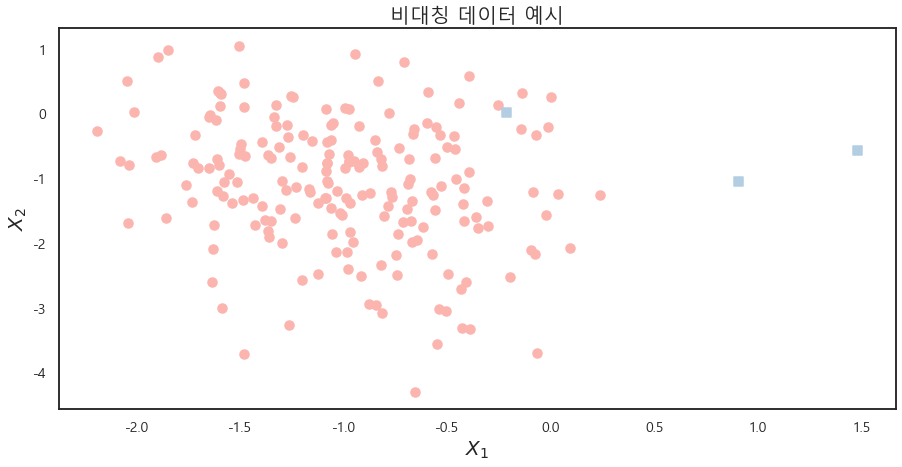

In [229]:
plt.figure(figsize=(15, 7))
plt.title("비대칭 데이터 예시", fontsize=20)

X, y = make_classification(n_samples=200, n_features=2, n_informative=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99, 0.01], random_state=5)

plt.scatter(X[:, 0][y==0], X[:, 1][y==0], marker="o")
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], marker="s")

plt.xlabel("$X_1$", fontsize=20)
plt.ylabel("$X_2$", fontsize=20)
plt.show();

- Class가 99:1로 불균형한 상황에서, 위와 같이 데이터가 분포되어 있다면 어떨까요? 먼저 [실험 4]와 같이 Balanced Accuracy를 이용하여 성능을 확인하고, Hyperplane의 형태를 살펴보겠습니다.

### __<span style="color:teal">Case 1-1: class_weight=None, C=1.0__

In [230]:
model_imbalance_C1 = SVC(kernel='linear', class_weight=None, C=1.0)

# 결과 확인
rich.print(f'[bold] Stratified Cross-validation Balanced Accuracy scores with soft margin svm (no class weight, C=1.0), {cross_val_score(model_imbalance_C1, X, y, cv=kfold, scoring="balanced_accuracy").mean()}')

 Stratified Cross-validation Balanced Accuracy scores with soft margin svm (no class weight, C=1.0), 0.7

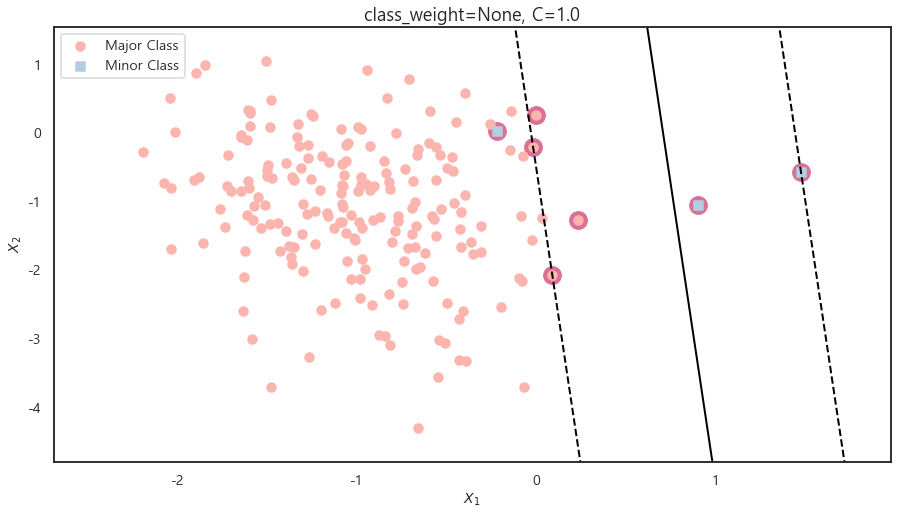

In [179]:
# Imbalanced Case 1: class_weight=None, C=1.0
model_imbalance_C1 = SVC(kernel='linear', class_weight=None, C=1)
model_imbalance_C1.fit(X, y)

plt.figure(figsize=(15, 8))

w = model_imbalance_C1.coef_[0]        # Weights assigned to the features (coefficients in the primal problem).
b = model_imbalance_C1.intercept_[0]   # Constants in decision function.

x0 = np.linspace(np.min(X[:, 0])-0.5, np.max(X[:, 0])+0.5, 200)

decision_boundary = -w[0]/w[1] * x0 - b/w[1]

margin = 1/w[1]

gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin

svs = model_imbalance_C1.support_vectors_  # support vectors

plt.scatter(svs[:, 0], svs[:, 1], s=300, facecolors='palevioletred')
plt.plot(x0, decision_boundary, "k-", linewidth=2)
plt.plot(x0, gutter_up, "k--", linewidth=2)
plt.plot(x0, gutter_down, "k--", linewidth=2)

plt.scatter(X[:, 0][y==0], X[:, 1][y==0], marker="o", label="Major Class")
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], marker="s", label="Minor Class")

plt.title("class_weight=None, C=1.0", fontsize=18)
plt.xlabel("$X_1$", fontsize=14)
plt.ylabel("$X_2$", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([np.min(X[:, 0])-0.5, np.max(X[:, 0])+0.5, np.min(X[:, 1])-0.5, np.max(X[:, 1])+0.5])

plt.show();

### __<span style="color:teal">Case 1-2: class_weight=None, C=1000000__

In [231]:
model_imbalance_largeC = SVC(kernel='linear', class_weight=None, C=10**7)

# 결과 확인
rich.print(f'[bold] Stratified Cross-validation Balanced Accuracy scores with soft margin svm (no class weight, C=10000000), {cross_val_score(model_imbalance_largeC, X, y, cv=kfold, scoring="balanced_accuracy").mean()}')

 Stratified Cross-validation Balanced Accuracy scores with soft margin svm (no class weight, C=10000000), 0.8

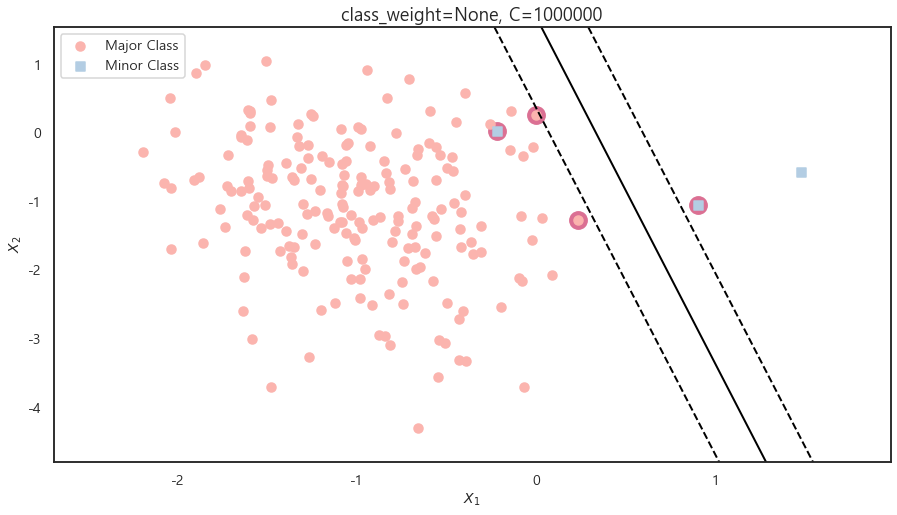

In [234]:
plt.figure(figsize=(15, 8))
model_imbalance_C100.fit(X, y)

w = model_imbalance_C100.coef_[0]        # Weights assigned to the features (coefficients in the primal problem).
b = model_imbalance_C100.intercept_[0]   # Constants in decision function.

x0 = np.linspace(np.min(X[:, 0])-0.5, np.max(X[:, 0])+0.5, 200)

decision_boundary = -w[0]/w[1] * x0 - b/w[1]

margin = 1/w[1]

gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin

svs = model_imbalance_C100.support_vectors_  # support vectors

plt.scatter(svs[:, 0], svs[:, 1], s=300, facecolors='palevioletred')
plt.plot(x0, decision_boundary, "k-", linewidth=2)
plt.plot(x0, gutter_up, "k--", linewidth=2)
plt.plot(x0, gutter_down, "k--", linewidth=2)

plt.scatter(X[:, 0][y==0], X[:, 1][y==0], marker="o", label="Major Class")
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], marker="s", label="Minor Class")

plt.title("class_weight=None, C=1000000", fontsize=18)
plt.xlabel("$X_1$", fontsize=14)
plt.ylabel("$X_2$", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([np.min(X[:, 0])-0.5, np.max(X[:, 0])+0.5, np.min(X[:, 1])-0.5, np.max(X[:, 1])+0.5])

plt.show();

### __<span style="color:teal">Case 2-1: class_weight='balanced', C=1__

In [232]:
model_balance_C1 = SVC(kernel='linear', class_weight='balanced', C=1)

# 결과 확인
rich.print(f'[bold] Stratified Cross-validation Balanced Accuracy scores with soft margin svm (balanced class weight, C=1), {cross_val_score(model_balance_C1, X, y, cv=kfold, scoring="balanced_accuracy").mean()}')

 Stratified Cross-validation Balanced Accuracy scores with soft margin svm (balanced class weight, C=1), 
0.8596153846153847

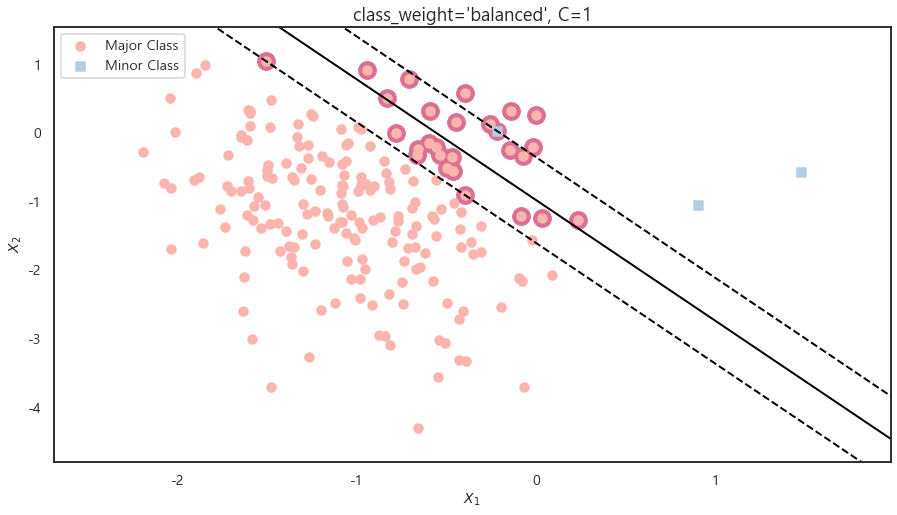

In [239]:
plt.figure(figsize=(15, 8))
model_balance_C1.fit(X, y)

w = model_balance_C1.coef_[0]        # Weights assigned to the features (coefficients in the primal problem).
b = model_balance_C1.intercept_[0]   # Constants in decision function.

x0 = np.linspace(np.min(X[:, 0])-0.5, np.max(X[:, 0])+0.5, 200)

decision_boundary = -w[0]/w[1] * x0 - b/w[1]

margin = 1/w[1]

gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin

svs = model_balance_C1.support_vectors_  # support vectors

plt.scatter(svs[:, 0], svs[:, 1], s=300, facecolors='palevioletred')
plt.plot(x0, decision_boundary, "k-", linewidth=2)
plt.plot(x0, gutter_up, "k--", linewidth=2)
plt.plot(x0, gutter_down, "k--", linewidth=2)

plt.scatter(X[:, 0][y==0], X[:, 1][y==0], marker="o", label="Major Class")
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], marker="s", label="Minor Class")

plt.title("class_weight='balanced', C=1", fontsize=18)
plt.xlabel("$X_1$", fontsize=14)
plt.ylabel("$X_2$", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([np.min(X[:, 0])-0.5, np.max(X[:, 0])+0.5, np.min(X[:, 1])-0.5, np.max(X[:, 1])+0.5])

plt.show();

### __<span style="color:teal">Case 2-2: class_weight='balanced', C=1000000__

In [233]:
model_balance_largeC = SVC(kernel='linear', class_weight='balanced', C=10**7)

# 결과 확인
rich.print(f'[bold] Stratified Cross-validation Balanced Accuracy scores with soft margin svm (balanced class weight, C=10^7), {cross_val_score(model_balance_largeC, X, y, cv=kfold, scoring="balanced_accuracy").mean()}')

 Stratified Cross-validation Balanced Accuracy scores with soft margin svm (balanced class weight, C=10^7), 
0.8697435897435899

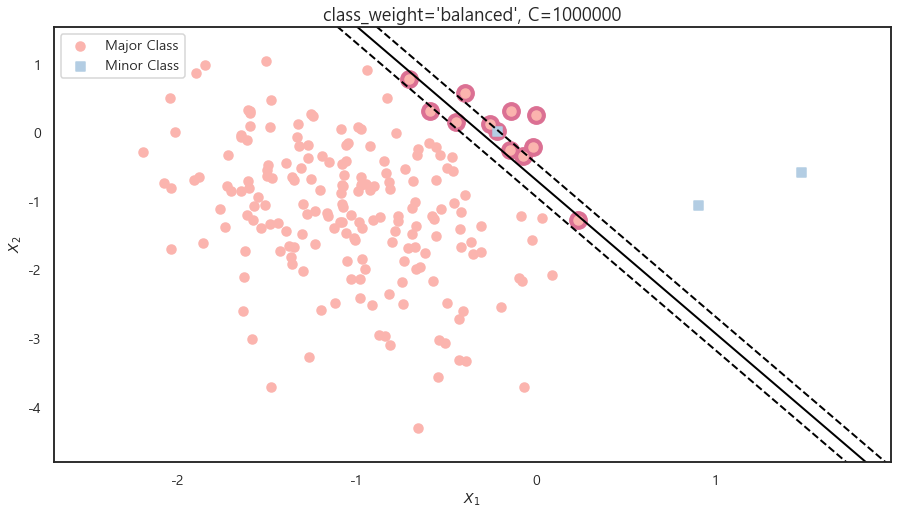

In [240]:
plt.figure(figsize=(15, 8))
model_balance_largeC.fit(X, y)

w = model_balance_largeC.coef_[0]        # Weights assigned to the features (coefficients in the primal problem).
b = model_balance_largeC.intercept_[0]   # Constants in decision function.

x0 = np.linspace(np.min(X[:, 0])-0.5, np.max(X[:, 0])+0.5, 200)

decision_boundary = -w[0]/w[1] * x0 - b/w[1]

margin = 1/w[1]

gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin

svs = model_balance_largeC.support_vectors_  # support vectors

plt.scatter(svs[:, 0], svs[:, 1], s=300, facecolors='palevioletred')
plt.plot(x0, decision_boundary, "k-", linewidth=2)
plt.plot(x0, gutter_up, "k--", linewidth=2)
plt.plot(x0, gutter_down, "k--", linewidth=2)

plt.scatter(X[:, 0][y==0], X[:, 1][y==0], marker="o", label="Major Class")
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], marker="s", label="Minor Class")

plt.title("class_weight='balanced', C=1000000", fontsize=18)
plt.xlabel("$X_1$", fontsize=14)
plt.ylabel("$X_2$", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([np.min(X[:, 0])-0.5, np.max(X[:, 0])+0.5, np.min(X[:, 1])-0.5, np.max(X[:, 1])+0.5])

plt.show();

### __<span style="color:teal">[실험 5] 결과 해석__

위 4가지 Case에 대한 결과를 도표로 정리하자면 아래와 같습니다.

<br/>

|Case|Class_Weight|C|Hyperplane|Balanced Accuracy|Num of Support Vectores|
|:---:|:-------:|:---:|:-------:|:--------------:|:--------------------:|
|__Case 1-1__|None|1.0|C 값이 낮아 error를 많이 허용하기에 Margin이 매우 넓은 형태입니다.|__0.7__|6|
|__Case 1-2__|None|10000000.0|C 값이 크므로, error를 어떻게든 허용하지 않으려 하기 때문에 Margin이 상대적으로 좁은 형태입니다.|__0.8__|4|
|__Case 2-1__|'balanced' | 1.0|C 값이 작아 Margin이 상대적으로 넓지만, Class weight를 주지 않은 경우보다는 훨씬 좁은 형태입니다.|__0.85__|27|
|__Case 2-2__|'balanced'| 10000000.0|C 값이 크므로 Margin이 매우 좁고, Class weight를 주지 않은 경우와 비교했을 때 가장 좁은 Margin을 가진 Hyperplane이 형성되었습니다.|__0.87__|12|

- __<span style="color:teal">Class Weight을 주지 않았을 때(None)와 'balanced'로 맞춰주었을 경우에는 Hyperplane의 형태__ 가 매우 다릅니다.
    - __Class Weight을 반영하지 않는다면 다수의 Major Class에 유리한 방향으로 Decision Boundary가 그어집니다.__
    - 반면 __<span style="color:teal"> 불균형 상황을 고려한 경우에는 새로운 데이터가 들어오더라도 Minor Class에 속할 여지를 주기 위해 Major Class에 조금 더 불리한 방향으로 Decision Boundary가 그어졌음을 확인__ 할 수 있습니다.
    - 이는 __Class Wegiht을 주었을 때 C가 1.0이더라도 margin이 상대적으로 좁은 이유와 더불어 margin 평면을 벗어난 Support Vectors가 가장 많은 이유__ 이기도 합니다. __<span style="color:teal">다수 Class에 불리한 방향으로 결정 경계가 형성되었기 때문에 Support Vectors가 상대적으로 많을 수밖에 없는 것__ 입니다.

- 더불어 __<span style="color:teal">Balanced Accuracy 기준으로 성능을 확인하였을 때, class_weight 인자에 'balanced' 값을 넣어주었을 때가 상대적으로 더 우수한 성능__ 을 내며, 특히 __<span style="color:teal">C 값이 높아 에러를 적게 허용하는 경우에 가장 우수한 성능__ 을 확인할 수 있었습니다.
     - 이는 앞선 Hard Margin SVM Case와는 다른 결과로, C 값이 +inf였던 Hard Margin SVM과는 다르게 __<span style="color:teal">관측치의 빈도인 class_weight=`n_samples / (n_classes * np.bincount(y))`가 실수 C 값에 곱한 채로 가중되었기 때문__ 입니다. 

------------------

## __1.3 Non linear Support Vector Machine__

1.2 까지는 데이터가 선형으로 분리될 수 있는 경우를 보았습니다. 그러나 실제 현실 세계에서는 선형으로 깔끔하게 분리할 수 없는 경우가 더 많습니다. 이를 __비선형 데이터__ 라고 하며, 이를 다루는 한 가지 방법 중 하나는 아래와 같이 __다항 특성(Polynomial features)__ 을 추가하는 것입니다. Linear로는 분리되지 않는다면 Nonlinear 특성을 추가하여 분리해보는 것이죠

## 1.3.1 선형 분리되지 않는 데이터셋: Polynomial Features 추가하기

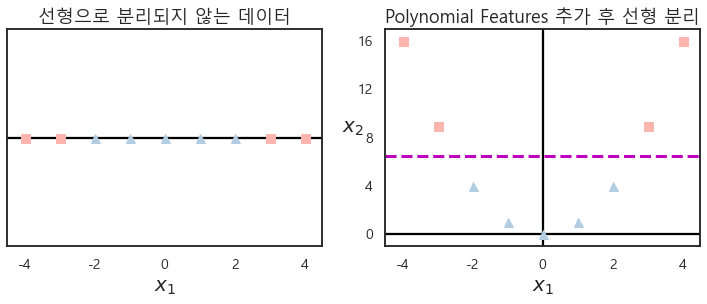

In [340]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "s")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "^")
plt.gca().get_yaxis().set_ticks([])
plt.title("선형으로 분리되지 않는 데이터")
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "s")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "m--", linewidth=3)
plt.title("Polynomial Features 추가 후 선형 분리")
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)
plt.show()

이러한 특성을 가지는 대표적인 데이터셋이 `Scikit-Learn`에서 제공하는 `make_moons` 데이터셋입니다. 두 개의 반달 모양을 가지는 데이터는 선형으로 분리하기 어렵습니다. 이러한 점을 바탕으로 다항 특성을 추가하여 데이터셋을 분류해보겠습니다.

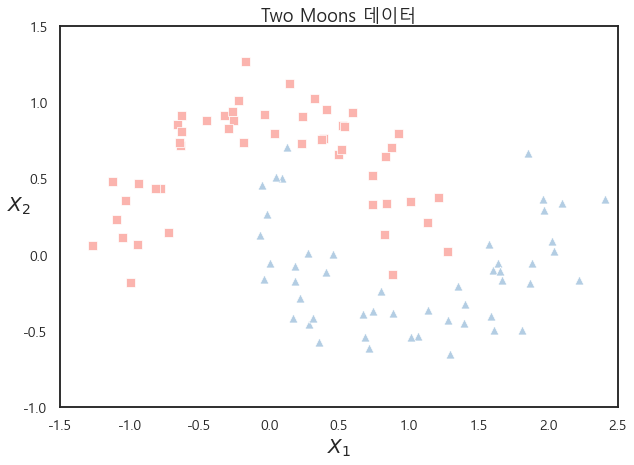

In [349]:
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

plt.figure(figsize=(10, 7))
sns.scatterplot(X[:, 0][y==0], X[:, 1][y==0], marker="s")
sns.scatterplot(X[:, 0][y==1], X[:, 1][y==1], marker="^")
plt.axis([-1.5, 2.5, -1, 1.5])
plt.xlabel(r"$X_1$", fontsize=20)
plt.ylabel(r"$X_2$", fontsize=20, rotation=0)
plt.title("Two Moons 데이터")
plt.show()

이제 위 __데이터셋에 다항 특성을 추가__ 하고, 이를 __Linear SVM__ 으로 분류해보겠습니다.
- Linear SVM의 Hyperparameter 중 `C`는 default 값인 1로 설정하였습니다.

In [354]:
lineasvm_polyfeatures = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='linear', C=1))
])

# 결과 확인
lineasvm_polyfeatures.fit(X, y)
# rich.print(f'[bold] Stratified Cross-validation Accuracy scores with Non linear features (C=1), {cross_val_score(lineasvm_polyfeatures, X_scaled, y, cv=kfold, scoring="accuracy").mean()}')

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', SVC(C=1, kernel='linear'))])

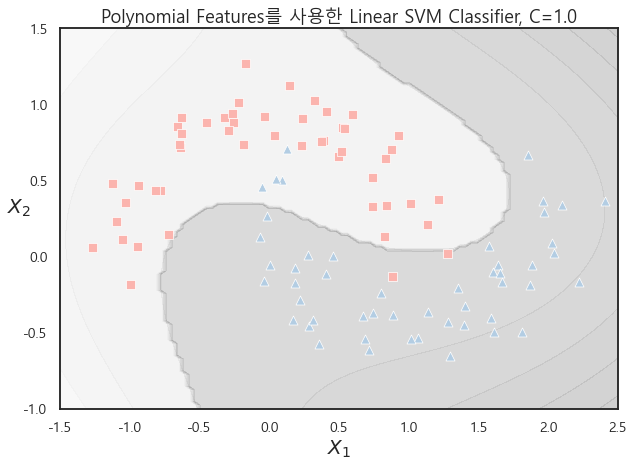

In [370]:
plt.figure(figsize=(10, 7))

axes = [-1.5, 2.5, -1, 1.5]
x0s = np.linspace(axes[0], axes[1], 100)
x1s = np.linspace(axes[2], axes[3], 100)
x0, x1 = np.meshgrid(x0s, x1s)
X = np.c_[x0.ravel(), x1.ravel()]
y_pred = lineasvm_polyfeatures.predict(X).reshape(x0.shape)
y_decision = lineasvm_polyfeatures.decision_function(X).reshape(x0.shape)
plt.contourf(x0, x1, y_decision, cmap=plt.cm.binary, alpha=0.1)
plt.contourf(x0, x1, y_pred, cmap=plt.cm.binary, alpha=0.1)

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

sns.scatterplot(X[:, 0][y==0], X[:, 1][y==0], marker="s")
sns.scatterplot(X[:, 0][y==1], X[:, 1][y==1], marker="^")
plt.axis([-1.5, 2.5, -1, 1.5])
plt.xlabel(r"$X_1$", fontsize=20)
plt.ylabel(r"$X_2$", fontsize=20, rotation=0)

plt.title('Polynomial Features를 사용한 Linear SVM Classifier, C=1.0')
plt.show();

- 선형이 아닌 다항의 Hyperplane이 형성되며, 데이터가 어느 정도 구분되는 것을 확인하였습니다. 이때 __C의 값을 늘리면 오류가 적은 Hyperplane이 형성되지 않을까요?__

In [371]:
lineasvm_polyfeatures = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='linear', C=100))
])

# 결과 확인
lineasvm_polyfeatures.fit(X, y)
# rich.print(f'[bold] Stratified Cross-validation Accuracy scores with Non linear features (C=1), {cross_val_score(lineasvm_polyfeatures, X_scaled, y, cv=kfold, scoring="accuracy").mean()}')

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', SVC(C=100, kernel='linear'))])

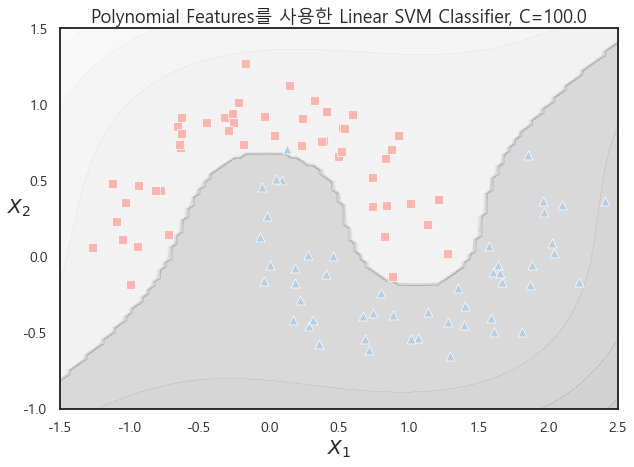

In [373]:
plt.figure(figsize=(10, 7))

axes = [-1.5, 2.5, -1, 1.5]
x0s = np.linspace(axes[0], axes[1], 100)
x1s = np.linspace(axes[2], axes[3], 100)
x0, x1 = np.meshgrid(x0s, x1s)
X = np.c_[x0.ravel(), x1.ravel()]
y_pred = lineasvm_polyfeatures.predict(X).reshape(x0.shape)
y_decision = lineasvm_polyfeatures.decision_function(X).reshape(x0.shape)
plt.contourf(x0, x1, y_decision, cmap=plt.cm.binary, alpha=0.1)
plt.contourf(x0, x1, y_pred, cmap=plt.cm.binary, alpha=0.1)

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

sns.scatterplot(X[:, 0][y==0], X[:, 1][y==0], marker="s")
sns.scatterplot(X[:, 0][y==1], X[:, 1][y==1], marker="^")
plt.axis([-1.5, 2.5, -1, 1.5])
plt.xlabel(r"$X_1$", fontsize=20)
plt.ylabel(r"$X_2$", fontsize=20, rotation=0)

plt.title('Polynomial Features를 사용한 Linear SVM Classifier, C=100.0')
plt.show();

- 확인 결과 __값을 1에서 100으로 높이면 훨씬 데이터를 잘 구분하고자 하는 모형의 Hyperplane이 형성__ 되었습니다.

## __1.3.2 선형 분리되지 않는 데이터셋: Kernel Trick 활용하기__

이처럼 다항식 특성을 추가하는 것은 매우 간단한 방법이지만, __많은 다항식 특성들이 추가되면 모델의 속도가 느려진다는 단점__ 이 있습니다. SVM에서는 이를 해결하기 위해서 __<span style="color:crimson">Kernel Trick__ 을 이용합니다. 다시 말해, __<span style="color:crimson">Kernel 함수를 이용해서 저차원에서 고차원으로 데이터를 mapping하여 해결하는 것__ 입니다. 이를 이용하는 SVM을 __Kernel SVM__ 이라 합니다. 그림을 참고하면 보다 직관적인 이해가 가능합니다. 2차원에서 3차원의 공간으로 mapping하는 것의 예는 아래와 같습니다.
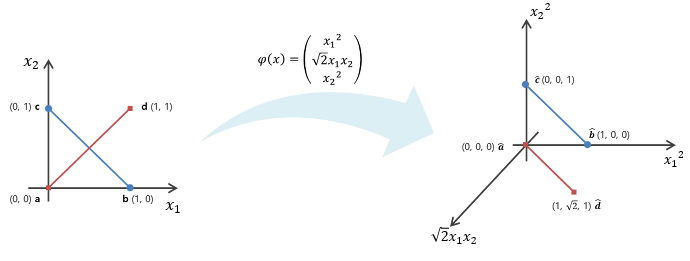

즉, D차원의 설명변수들이 존재한다면, 이를 설명변수 벡터 $x$ 대신 기저함수(basis function)으로 변환한 $M$차원 벡터 $\Phi(x)$를 설명변수로 사용하는 것입니다.   

$$\Phi(\cdot ):R^D \to R^M$$   

$$x = (x_1, x_2, ..., x_D) \quad \to \quad \Phi(x) = (\Phi_1(x), \Phi_2(x), ..., \Phi_M(x))$$

### __(참고) Kernel Trick__

앞서 Support Vector Machine의 Objective Function을 아래와 같이 Dual Form으로 표현하였습니다.

$$
L =  \sum_{i=1}^n \alpha_i - \frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}\alpha_i\alpha_jy_iy_jx^T_ix_j
$$


$$
y = w^T x - w_0 = \sum_{i=1}^n a_i y_i x_i^T x - w_0
$$

이 수식에서 $x$를 기저함수 변환으로 $\phi(x)$로 바꾸면

$$
L =  \sum_{i=1}^n x_i - \dfrac{1}{2}\sum_{i=1}^N\sum_{j=1}^n a_i a_j y_i y_j \phi(x_i)^T \phi(x_j)
$$


$$
y = w^T x - w_0 = \sum_{i=1}^n a_i y_i \phi(x_i)^T \phi(x) - w_0
$$

이 됩니다. 즉 모든 기저함수는 $\phi(x_i)^T\phi(x_j)$의 형태로만 사용되며 독립적으로 사용되지는 않습니다.

따라서 두 개의 변환된 독립 변수 벡터를 내적한 값 $\phi(x_i)^T\phi(x_j)$를 하나의 함수로 나타낼 수 있는 것입니다.

$$ k(x_i, x_j) = \phi(x_i)^T \phi(x_j) $$

이러한 함수를 __커널(kernel)__ 이라고 합니다.

__Kernel Trick을 이용한 SVM의 Objective Function을 표현하자면 아래와 같습니다.__
$$
L =  \sum_{i=1}^n a_i - \dfrac{1}{2}\sum_{i=1}^N\sum_{j=1}^n \alpha_i \alpha_j y_i y_j k(x_i, x_j)
$$


$$
y = w^T x - w_0 = \sum_{i=1}^N \alpha_i y_i k(x_i, x) - w_0
$$

이때 커널을 사용하지 않는 경우 $ k(x, y) = x^Ty $라는 점을 고려하면, 커널은 다음과 같은 특징을 보이기도 합니다.

* $x$와 $y$가 동일한 벡터일 때 가장 크고
* 두 벡터간의 거리가 멀어질 수록 작아진다.

즉, 두 __표본 데이터 간의 유사도(similarity)를 측정하는 기준__ 으로 볼 수도 있습니다.

__Kernel의 종류__   
앞서 실험을 진행하면서, SVC 클래스에는 kernel 인자가 있음을 확인한 바 있습니다. 그 종류는 아래와 같습니다.

__linear (선형)__
- $K(a, b) = a^T\cdot b$

__poly (다항식)__
- $K(a, b) = (\gamma^T\cdot b+\gamma)^d$

__가우시안 (rbf)__
- $K(a, b)=exp(-\gamma||a-b||^2)$

__시그모이드 (Sigmoid)__
- $tanh(\gamma^T\cdot+\gamma)$

## __1.3.3 다항 커널__

다항 커널은 벡터의 내적으로 정의된 커널을 확장하여 만든 커널입니다. 그 기저 함수에 대한 예는 아래와 같은데,

간단한 경우로 $\gamma=1$, $\theta=1$, $d=3$이고 $x$가 스칼라인 상황을 가정하겠습니다.

\begin{eqnarray}
k(x_1, x_2) 
&=& (x_1^Tx_2 + 1)^4 \\
&=& x_1^4x_2^4 + 4x_1^3x_2^3 + 6x_1^2x_2^2 + 4x_1x_2 + 1 \\
&=& (x_1^4, 2x_1^3, \sqrt{6}x_1, 2x_1, 1)^T (x_2^4, 2x_2^3, \sqrt{6}x_2, 2x_2, 1) \ \\
\end{eqnarray}

<br/>

해당 경우에는 위처럼 기저함수의 내적으로 표현이 가능하며, 기저함수는 다음 5개가 됩니다.

<br/>

\begin{eqnarray}
\phi_1(x) &=& x^4 \\
\phi_2(x) &=& 2x^3 \\
\phi_3(x) &=& \sqrt{6}x^2 \\
\phi_4(x) &=& 2x \\
\phi_5(x) &=& 1 \\
\end{eqnarray}

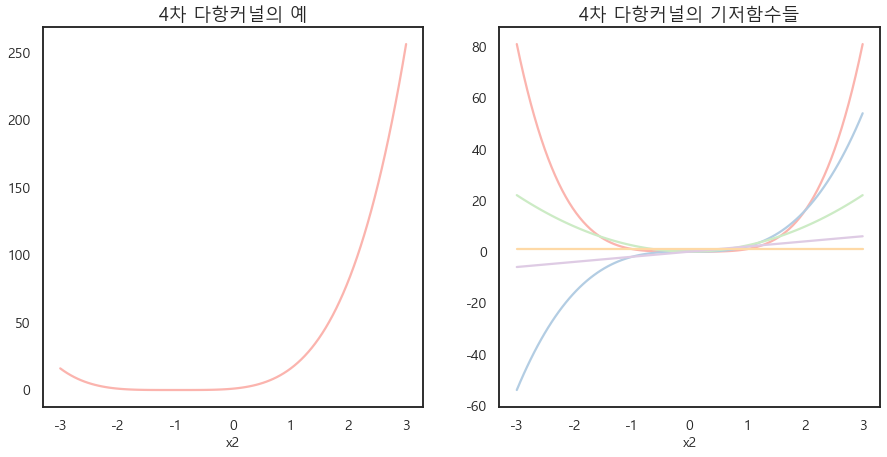

In [382]:
x1 = 1
x2 = np.linspace(-3, 3, 100)

def poly4(x1, x2):
    return (x1 * x2 + 1) ** 4

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(x2, poly4(x1, x2), ls="-")
plt.xlabel("x2")
plt.title("4차 다항커널의 예")

plt.subplot(122)
plt.plot(x2, x2 ** 4)
plt.plot(x2, 2 * x2 ** 3)
plt.plot(x2, np.sqrt(6) * x2 ** 2)
plt.plot(x2, 2 * x2)
plt.plot(x2, np.ones_like(x2))
plt.xlabel("x2")
plt.title("4차 다항커널의 기저함수들")

plt.show()

## 1.3.4 가우시안 RBF(Radial Basis Function) 커널

가우시안 rbf 커널은 무엇일까요? 보다 쉬운 이해를 위해서 다음과 같이 가정해보겠습니다.

<br/>

$$
\gamma=\frac{1}{2}
$$

$$
\|x_1\| = \|x_2\| = 1
$$

<br/>

이러한 상황이라면, RBF 커널은

<br/>

$$ 
\begin{eqnarray}
k(x_1, x_2) 
&=& \exp{\left(-\frac{||x_1 - x_2||^2}{2}\right)} \\
&=& \exp{\left(-\frac{x_1^Tx_1}{2} - \frac{x_2^Tx_2}{2} + 2x_1^Tx_2 \right)} \\
&=& \exp{\left(-\frac{x_1^Tx_1}{2}\right)}\exp{\left(-\frac{x_2^Tx_2}{2}\right)}\exp{(x_1^Tx_2)} \\
&=& C \exp{(x_1^Tx_2)} \\
&\approx& C \left( 1 + (x_1^Tx_2) + \dfrac{1}{2!}(x_1^Tx_2)^2 +  \dfrac{1}{3!}(x_1^Tx_2)^3 + \cdots \right) \\
\end{eqnarray}
$$

에서 차수가 무한대인 다항 커널과 같아집니다.

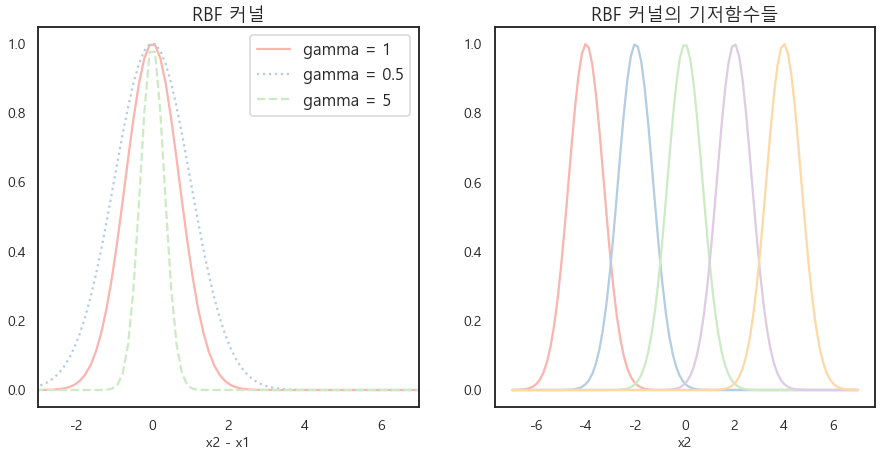

In [380]:
x1 = 0.0
x2 = np.linspace(-7, 7, 100)

def rbf(x1, x2, gamma):
    return np.exp(-gamma * np.abs(x2 - x1) ** 2)

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(x2, rbf(x1, x2, 1), ls="-", label="gamma = 1")
plt.plot(x2, rbf(x1, x2, 0.5), ls=":", label="gamma = 0.5")
plt.plot(x2, rbf(x1, x2, 5), ls="--", label="gamma = 5")
plt.xlabel("x2 - x1")
plt.xlim(-3, 7)
plt.legend(loc=1)
plt.title("RBF 커널")

plt.subplot(122)
plt.plot(x2, rbf(-4, x2, 1))
plt.plot(x2, rbf(-2, x2, 1))
plt.plot(x2, rbf(0, x2, 1))
plt.plot(x2, rbf(2, x2, 1))
plt.plot(x2, rbf(4, x2, 1))
plt.xlabel("x2")
plt.title("RBF 커널의 기저함수들")

plt.show();

----

### __<span style="color:teal">[실험 7] Kernel 별 분류 결과 비교__

앞서 SVM 클래스에는 kernel에 다양한 인자들을 넣어 비교할 수 있음을 확인하였습니다. 이때 __하나의 kernel에서도 다양한 하이퍼파라미터 값들이 존재__ 합니다. 이때 본 튜토리얼에서는 __다항 커널과 rbf 커널만을 비교__ 할 것이며, __<span style="color:teal">[실험 7]에서는 같은 데이터셋에 대해 두 kernel의 결과를 비교해보겠습니다.__

- Hyperparameter는 임의로 정하였습니다.

scikit-learn의 `SVM` 클래스

* `kernel = "linear"`: 선형 SVM. $k(x_1, x_2) = x_1^T x_2$ 
* `kernel = "poly"`: 다항 커널. $k(x_1, x_2) = (\gamma (x_1^Tx_2) + \theta)^d$ 
    * `gamma`: $\gamma$
    * `coef0`: $\theta$
    * `degree`: $d$
* `kernel = "rbf"` 또는 `kernel = None`: RBF 커널. $k(x_1, x_2) = \exp \left( -\gamma ||x_1-x_2||^2 \right)$
    * `gamma`: $\gamma$

In [401]:
def plot_dataset(X, y, axes):
    sns.scatterplot(X[:, 0][y==0], X[:, 1][y==0], marker="s")
    sns.scatterplot(X[:, 0][y==1], X[:, 1][y==1], marker="^")
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.binary, alpha=0.1)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.binary, alpha=0.1)

In [418]:
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

# 다항 커널
polysvc = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", gamma=5, degree=3, coef0=100, C=100))
    ])
polysvc.fit(X, y)

# rbf 커널
rbfsvc = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=100))
    ])
rbfsvc.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()), ('svm_clf', SVC(C=100, gamma=5))])

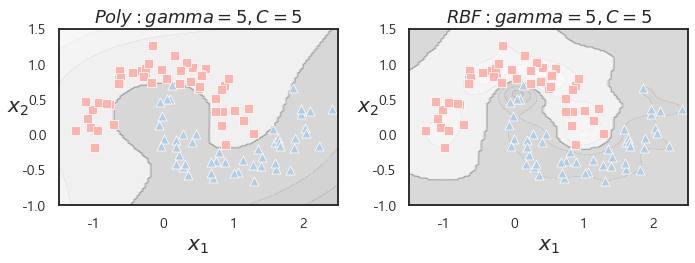

In [420]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plot_predictions(polysvc, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$Poly: gamma=5, C=5$", fontsize=18);

# plt.figure(figsize=(10, 4))
plt.subplot(122)
plot_predictions(rbfsvc, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$RBF: gamma=5, C=5$", fontsize=18);

plt.tight_layout();

### __<span style="color:teal">[실험 7] 결과 해석__

- 확인 결과 __<span style="color:teal">Poly Kernel은 경계면이 부드럽게 형성__ 되는 반면, __<span style="color:teal">RBF Kernel은 상대적으로 울퉁불퉁한 경계면을 형성합니다.
    - 이때 __RBF Kernel에서 gamma는 Regularization 역할을 하며, 값이 커지면 결정 경계가 불규칙하고 구부러진다는 특징__ 을 가집니다.
    
    <br/>
    
    - 같은 gamma를 사용했음애도 __<span style="color:teal">Poly에서는 상대적으로 부드러운 결정 경계가 형성된 이유__ 는 __<span style="color:teal">Poly Kernel에서 `coef0` 을 조절했기 때문입니다.
     - __<span style="color:teal">`coef0` 값을 적절히 조절하면 고차항의 영향을 줄일 수 있기에, 상대적으로 부드러운 Hyperplane이 형성된 것__ 을 확인할 수 있습니다.

-------------------

### __<span style="color:teal">[실험 8] RBF Kernel에서의 gamma 조절__

RBF Kernel $K(x_1, x_2) = \exp \left( -\gamma ||x_1-x_2||^2 \right)$ 에서, $\gamma$는 Regularization 역할을 수행합니다.
- __$\gamma$가 커지면__ 정규분포의 봉우리가 좁아져서 각 데이터에 대한 영향 범위가 작아지며, 따라서 __Decision Boundary가 불규칙하고 구부러진 형태__ 가 됩니다.
- 반면 __$\gamma$가 작아지면__ 넓은 종 모양의 형태가 생성되어, 데이터에 대한 영향이 넓어져 __상대적으로 결정 경계가 부드러워지게 됩니다.__

<br/>

- 따라서 __<span style="color:teal">[실험 8]에서는 $\gamma$ 값에 따른 Decision Boundary의 차이를 비교__ 해보겠습니다. 더불어 C에 따른 차이도 함께 확인해보고자 합니다.

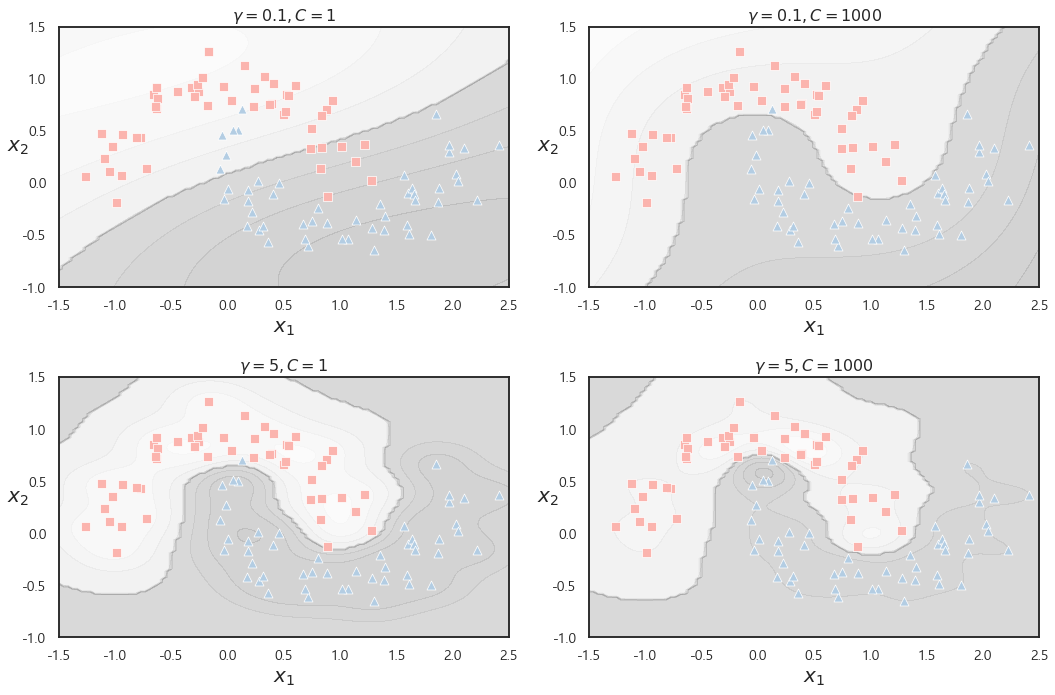

In [425]:
gamma1, gamma2 = 0.1, 5
C1, C2 = 1, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

plt.figure(figsize=(15, 10))

for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221 + i)
    plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)

plt.tight_layout();
plt.show()

### __<span style="color:teal">[실험 8] 결과 해석__

- 실험 결과 __<span style="color:teal">gamma 값이 0.1에서 5로 커질 수록 C 값과 상관 없이 부드러운 결정 경계가 형성됨__ 을 알 수 있습니다. 더불어 __<span style="color:teal">gamma가 커지면 Calss 1에 대한 결정 경계는 좁아집니다.__
- __<span style="color:teal">C가 커질 수록 Hyperplane은 어떻게든 두 개의 데이터셋을 구분하고자 하는 모습__ 을 gamma 값과 상관 없이 보여주고 있습니다.
    
<br/>
    
- 따라서 __<span style="color:teal">보다 부드러운 형태와 함께 Class 1과 Class 2에 대한 균일한 결정 경계를 형성하고 싶다면 gamma 값을 낮추어 데이터에 대한 영향 범위를 높이고, error 허용 여부에 따라서 C 값을 적절히 높이는 것이 해당 데이터셋에는 중요하다는 결론__ 을 지었습니다.

--------

## References

- https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
- https://github.com/ExcelsiorCJH/Hands-On-ML/blob/master/
- https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html